## Автор ноутбука: Виталий Карташов

В данном ноутбуке представлено решение для соревнования [Goodreads Books Reviews](https://www.kaggle.com/competitions/goodreads-books-reviews-290312/) на платформе kaggle, в рамках которого участникам предлагалось построить модель для прогноза рейтинга (количество поставленных звезд) на основе оставленных рецензий на портале [Goodreads](https://www.goodreads.com/).

На основе написанных отзывов необходимо было предсказать оценку, которую поставил пользователь (от 0 до 5 звезд).

Более подробно с описанием задачи можно ознакомиться на [странице соревнования](https://www.kaggle.com/competitions/goodreads-books-reviews-290312/).

В данном ноутбуке представлено решение на основе фреймворка [LightAutoML](https://github.com/sb-ai-lab/LightAutoML), которое дало публичный скор 0.57602 (топ-105 решений).

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.simplefilter(action='ignore')

with open('kaggle.json', 'r') as f:
  data = json.load(f)
  os.environ['KAGGLE_USERNAME'] = data["username"]
  os.environ['KAGGLE_KEY'] = data["key"]

In [ ]:
!kaggle competitions download -c goodreads-books-reviews-290312
!unzip goodreads-books-reviews-290312.zip
!rm -rf goodreads-books-reviews-290312.zip

 98% 624M/635M [00:07<00:00, 102MB/s] 
100% 635M/635M [00:07<00:00, 83.4MB/s]
Archive:  goodreads-books-reviews-290312.zip
  inflating: goodreads_sample_submission.csv  
  inflating: goodreads_test.csv      
  inflating: goodreads_train.csv     


In [ ]:
%%capture
!pip install git+https://github.com/sb-ai-lab/LightAutoML.git
!pip install optuna

In [ ]:
from lightautoml.automl.presets.text_presets import TabularNLPAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task

In [ ]:
df_train = pd.read_csv('goodreads_train.csv')
df_test = pd.read_csv('goodreads_test.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


## EDA

In [ ]:
# Посмотрим на размерность тренировочных и тестовых данных

print(f"Train dataset shape: {df_train.shape}")
print(f"Test dataset shape: {df_test.shape}")

Train dataset shape: (900000, 11)
Test dataset shape: (478033, 10)


In [ ]:
# Посмотрим общую информацию

df_train.info()
df_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB


,book_id,rating,n_votes,n_comments
count,9.000000e+05,900000.000000,900000.000000,900000.000000
mean,1.344145e+07,3.689639,3.294381,1.016656
std,9.357863e+06,1.252583,17.873553,5.963821
min,1.000000e+00,0.000000,-3.000000,-1.000000
25%,6.340471e+06,3.000000,0.000000,0.000000
50%,1.344203e+07,4.000000,0.000000,0.000000
75%,2.057897e+07,5.000000,2.000000,0.000000
max,3.632868e+07,5.000000,3222.000000,1335.000000


In [ ]:
votes_df = df_train.groupby('user_id')[['n_votes']].min().sort_values(by='n_votes', ascending=True)
print(f"Пользователей, которые оставили отрицательное количество оценок: {len(votes_df[votes_df['n_votes'] < 0])}")

Пользователей, которые оставили отрицательное количество оценок: 42


In [ ]:
comments_df = df_train.groupby('user_id')[['n_comments']].min().sort_values(by='n_comments', ascending=True)
print(f"Пользователей, оставивших отрицательное количество комментариев: {len(comments_df[comments_df['n_comments'] < 0])}")

Пользователей, оставивших отрицательное количество комментариев: 6


Каких-либо аномалий по данным нет. Значения колонки rating (наш таргет) находится в диапазоне от 0 до 5 включительно. Колонка n_votes (количество голосов) имеет 42 значения < 0 (то есть пользователь оставил -1 и более комметариев), что является выбросом. Также имеется 6 значений < 0 в колонке n_comments (количество комментариев) - выбросы.

### Посмотрим на таргет

In [ ]:
df_train['rating'].info()
df_train['rating'].describe()

<class 'pandas.core.series.Series'>
RangeIndex: 900000 entries, 0 to 899999
Series name: rating
Non-Null Count   Dtype
--------------   -----
900000 non-null  int64
dtypes: int64(1)
memory usage: 6.9 MB


count    900000.000000
mean          3.689639
std           1.252583
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
# Посмотрим на распределение количества элементов, приходящихся на каждый класс таргета

df_train[['rating']].value_counts()

rating
4         313688
5         265007
3         188972
2          72627
0          30988
1          28718
Name: count, dtype: int64

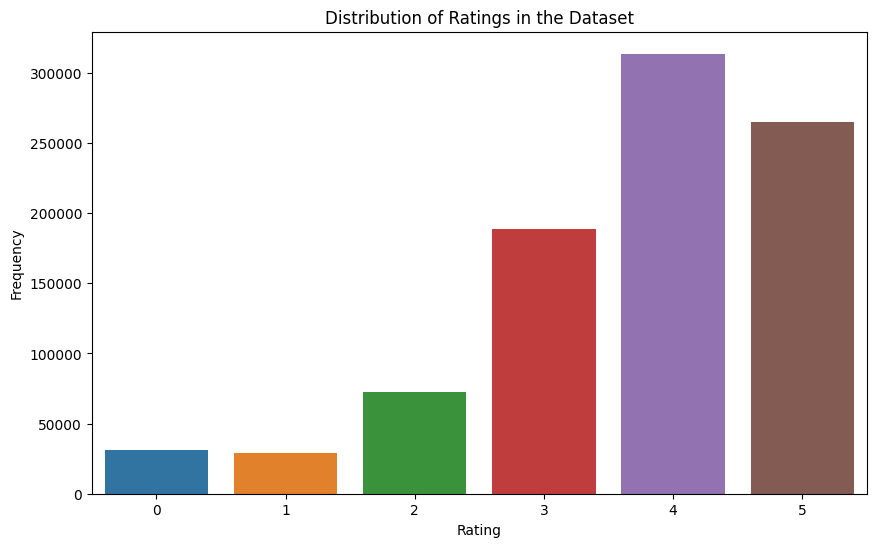

In [ ]:
# Визуализируем распределение таргета

plt.figure(figsize=(10, 6))
sns.barplot(x=df_train.groupby(['rating']).count().index.tolist(), y=df_train.groupby(['rating']).review_id.count())

plt.title('Distribution of Ratings in the Dataset')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

Наиболее часто пользователи оставляли 3 и более баллов. В меньшей степени пользователи оставляли негативные отметки (от 0 до 3 баллов).

### Анализ объектов-признаков

In [ ]:
df_train.head()

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
1,8842281e1d1347389f2ab93d60773d4d,16981,a5d2c3628987712d0e05c4f90798eb67,3,Recommended by Don Katz. Avail for free in Dec...,Mon Dec 05 10:46:44 -0800 2016,Wed Mar 22 11:37:04 -0700 2017,NaN,NaN,1,0
2,8842281e1d1347389f2ab93d60773d4d,28684704,2ede853b14dc4583f96cf5d120af636f,3,"A fun, fast paced science fiction thriller. I ...",Tue Nov 15 11:29:22 -0800 2016,Mon Mar 20 23:40:27 -0700 2017,Sat Mar 18 23:22:42 -0700 2017,Fri Mar 17 23:45:40 -0700 2017,22,0
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,NaN,NaN,5,1
4,8842281e1d1347389f2ab93d60773d4d,25884323,332732725863131279a8e345b63ac33e,4,"I really enjoyed this book, and there is a lot...",Mon Apr 25 09:31:23 -0700 2016,Mon Apr 25 09:31:23 -0700 2016,Sun Jun 26 00:00:00 -0700 2016,Sat May 28 00:00:00 -0700 2016,9,1


Проанализируем признаки - посмотрим на пропуски значений

In [ ]:
df_cleaned = df_train.dropna() # Удаляем строки там, где есть пропуски значений

print(f"Исходный датасет (df_train): {df_train.shape}")
print(f"Очищенный датасет (df_cleaned): {df_cleaned.shape}")

Исходный датасет (df_train): (900000, 11)
Очищенный датасет (df_cleaned): (615507, 11)


In [ ]:
df_train.info()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900000 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       900000 non-null  object
 1   book_id       900000 non-null  int64 
 2   review_id     900000 non-null  object
 3   rating        900000 non-null  int64 
 4   review_text   900000 non-null  object
 5   date_added    900000 non-null  object
 6   date_updated  900000 non-null  object
 7   read_at       808234 non-null  object
 8   started_at    625703 non-null  object
 9   n_votes       900000 non-null  int64 
 10  n_comments    900000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 75.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 615507 entries, 0 to 899999
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       615507 non-null  object
 1   book_id       615507 non-null  int64 
 

Оценим зависимость признаков друг от друга. Для этого немного преобразуем датасет в числовые признакы.


In [ ]:
# Переведем сначала строку типа 'Sun Jul 01 00:00:00 -0700 2017' в datetime, после чего в int (кол-во секунд)

%%capture
from datetime import datetime
date_format = '%a %b %d %H:%M:%S %z %Y'

df_cleaned['date_added_dt'] = df_cleaned['date_added'].apply(lambda x: datetime.strptime(x, date_format).timestamp())
df_cleaned['date_updated_dt'] = df_cleaned['date_updated'].apply(lambda x: datetime.strptime(x, date_format).timestamp())
df_cleaned['read_at_dt'] = df_cleaned['read_at'].apply(lambda x: datetime.strptime(x, date_format).timestamp())
df_cleaned['started_at_dt'] = df_cleaned['started_at'].apply(lambda x: datetime.strptime(x, date_format).timestamp())

# Дропаем оригинальные колонки

df_cleaned.drop(columns=['date_added'], inplace=True)
df_cleaned.drop(columns=['date_updated'], inplace=True)
df_cleaned.drop(columns=['read_at'], inplace=True)
df_cleaned.drop(columns=['started_at'], inplace=True)

In [ ]:
# Преобразуем датасет

df_metric_corr_check = df_cleaned.drop(columns=['user_id','review_id','review_text'])

array([[<Axes: title={'center': 'book_id'}>,
        <Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'n_votes'}>],
       [<Axes: title={'center': 'n_comments'}>,
        <Axes: title={'center': 'date_added_dt'}>,
        <Axes: title={'center': 'date_updated_dt'}>],
       [<Axes: title={'center': 'read_at_dt'}>,
        <Axes: title={'center': 'started_at_dt'}>, <Axes: >]],
      dtype=object)

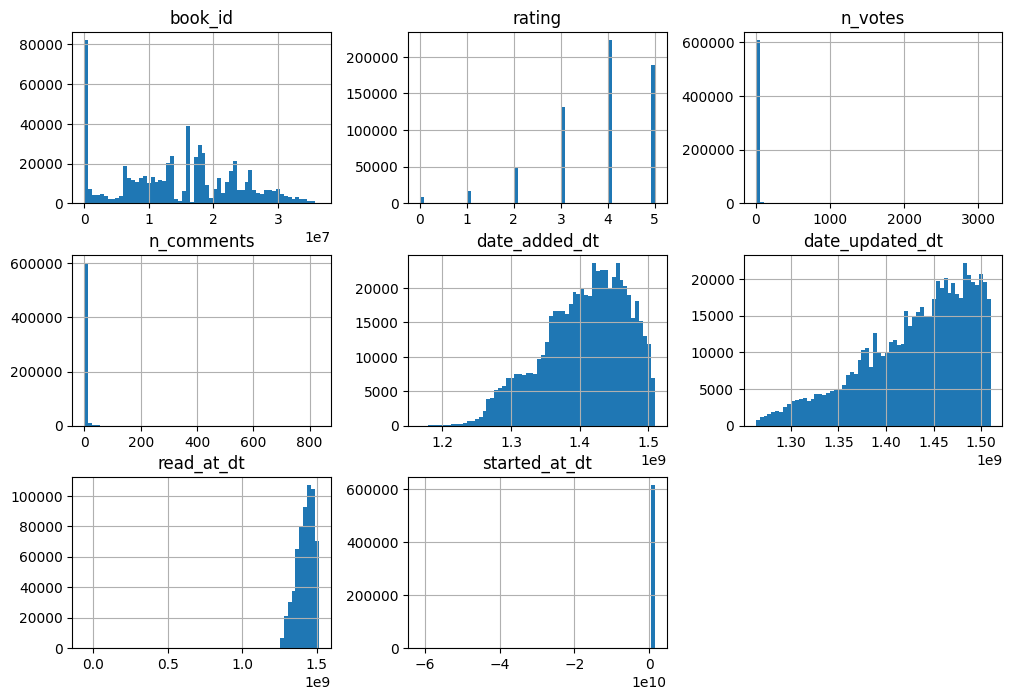

In [ ]:
# Посмотрим на значения признаков

df_metric_corr_check.hist(bins=60, figsize=(12, 8))

In [ ]:
# Посмотрим корреляцию числовых признаков

df_metric_corr_check.corr()

,book_id,rating,n_votes,n_comments,date_added_dt,date_updated_dt,read_at_dt,started_at_dt
book_id,1.000000,0.032398,0.080987,0.029116,0.548058,0.444214,0.498706,0.122962
rating,0.032398,1.000000,0.021954,0.009302,-0.021778,0.003619,-0.003858,-0.000646
n_votes,0.080987,0.021954,1.000000,0.649478,0.058494,0.086783,0.065556,0.016466
n_comments,0.029116,0.009302,0.649478,1.000000,-0.026359,0.001862,-0.024490,-0.005404
date_added_dt,0.548058,-0.021778,0.058494,-0.026359,1.000000,0.803341,0.881174,0.216035
date_updated_dt,0.444214,0.003619,0.086783,0.001862,0.803341,1.000000,0.868643,0.212533
read_at_dt,0.498706,-0.003858,0.065556,-0.024490,0.881174,0.868643,1.000000,0.243584
started_at_dt,0.122962,-0.000646,0.016466,-0.005404,0.216035,0.212533,0.243584,1.000000


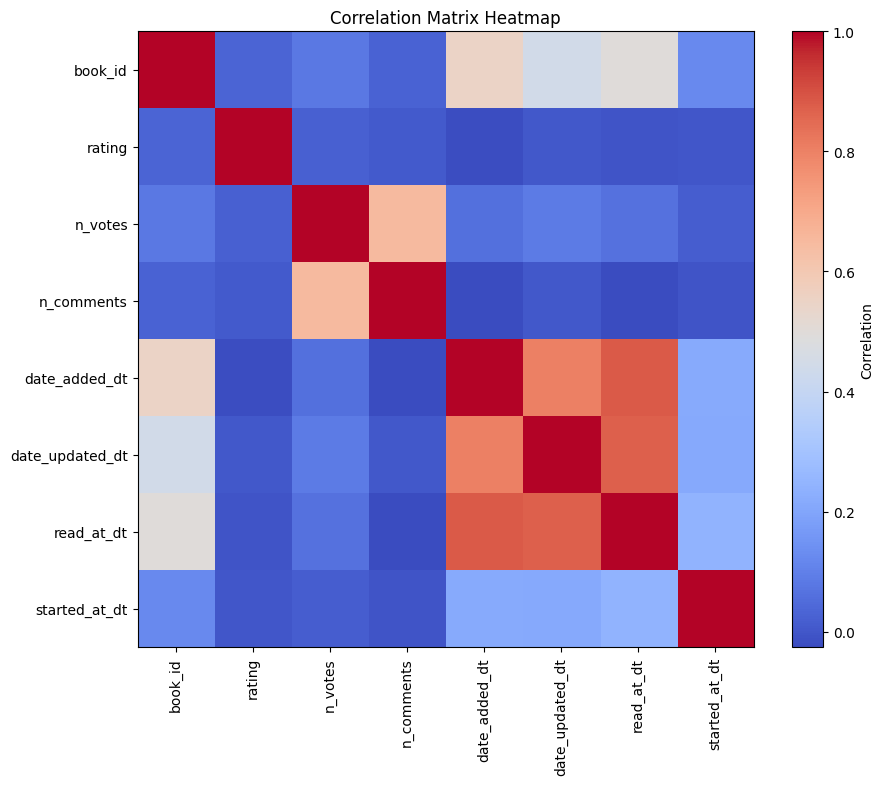

In [ ]:
# Визуализация матрицы корреляций

plt.figure(figsize=(10, 8))
plt.imshow(df_metric_corr_check.corr(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(df_metric_corr_check.corr().columns)), df_metric_corr_check.corr().columns, rotation=90)
plt.yticks(range(len(df_metric_corr_check.corr().columns)), df_metric_corr_check.corr().columns)
plt.title('Correlation Matrix Heatmap')
plt.show()

В целом мы видим, что данные не являются сильно скоррелированными. Имеется устойчивая связь (>0.5) между данными, связанными с информацией о комментариях: n_votes (количество голосов) и n_comments (количество комментариев), а также date_updated_dt (дата обновления комментария) и read_at_dt (время прочтения).

### Более детально проанализируем review_text

In [ ]:
# Посмотрим на столбец review_text

df_train['review_text'].sample(2).tolist()

["Very rarely do I read a book that never draws me in, not even a little bit. I put this book down with ten pages left earlier this morning, and wasn't upset at all. Darrow was a protagonist I never related to or rooted for. I understand that he's not supposed to be like-able. That's fine. I loved The Great Gatsby and none of those characters are like-able. The whole time, I felt like I was reading The Hunger Games repackaged for adults. If I hadn't paid for this (which is disappointing since I almost never buy books, being a broke college student) I would not have finished it.",
 "Shit, Shit, Shit.... OKAY- so let me just say I rated this 5 stars because as a whole (all three books) I was totally in love. I have a hard on for Gideon Cross and Damien Stark so I am biased in all things involving these two characters. Being this is Damien Stark's story I am going to rate it high. \n Pro's: \n *I got my closure that I needed with Nikki and Damien (sort of- yes, sort of, because I needed m

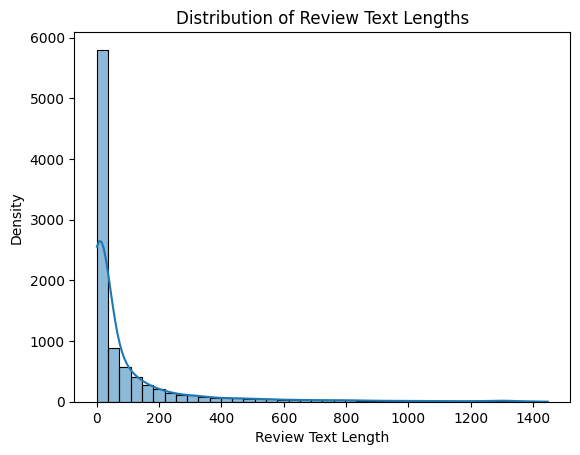

In [ ]:
# Посмотрим на длину (количество символов) в отзывах

sns.histplot(df_train['review_text'].str.len().value_counts(), kde=True, bins=40)
plt.xlabel('Review Text Length')
plt.ylabel('Density')
plt.title('Distribution of Review Text Lengths')
plt.show()

Видим, что коротких по длине отзывов больше, чем длинных.

### Анализ возможных преобразования и генерации новых признаков

Для реализации одного из подходов в LightAutoMl нам необходимо немного почистить текст.

In [ ]:
text = df_train['review_text'].iloc[0]

In [ ]:
import re

def replace_words_with_repeats(text, replacement='EMOTION'):
    pattern = r'\b\w*(\w)\1{2,}\w*\b' # Заменяем повтор символов (более двух подряд) на константные значения
    return re.sub(pattern, replacement, text)


def clean_text(text):
    text = text.lower()  # Преобразуем в нижний регистр
    text = re.sub(r'[^\w\s]', ' ', text)  # Удалим все символы, не являющиеся словами
    text = re.sub(r'\n', '', text)
    text = replace_words_with_repeats(text)
    text = re.sub(r'\s+', ' ', text)
    return text


In [ ]:
df_train['review_text_cleaned'] = df_train['review_text'].apply(lambda x: clean_text(x))

In [ ]:
# Также посмотрим на небольшие по количеству символов ревью

df_train[df_train['review_text_cleaned'].str.len() < 10][['review_text_cleaned']]

,review_text_cleaned
679,cute
688,loved it
5450,loved it
5807,loved it
6552,ugh
...,...
895873,reread
895874,reread
896803,loved it
899462,good read


## Lama baseline

Проверим несколько конфигураций LightAutoMl для классификации отзывов.
- Быстрый вариант решения задачи (дефолтный и с определением модели для векторизации эмбеддингов)
- Решение задачи с препроцессингом текста
- Ручное выставление гиперпараметров (с использованием optuna)


Для нахождения оптимального варианта использования LightAutoML уменьшим размер тренировочных данных до 150000, на которых проверим резульататы различных подходов

In [ ]:
# Определеяем метрику, которой будем оценивать наши результаты - в данном случае используем f1_score (weighted)

from sklearn.metrics import f1_score
def f1_weighted(y_true, y_pred):
    return f1_score(y_true, np.argmax(y_pred, axis=1), average='weighted')

In [ ]:
# Определяем константные значения

import os
import torch
N_THREADS = os.cpu_count() # Количество vCPUs для LightAutoM
GPU_IDS = '0' if torch.cuda.is_available() else None
TEST_SIZE = 0.2
RANDOM_STATE = 42
TIMEOUT = 200
TARGET_NAME = 'rating'

In [ ]:
# Уменьшим исходную тренировочную выборку для тестирования LightAutoMl

train_data = df_train.sample(150000).reset_index(drop=True)

print(f"Размер исходного тренировочного датасета: {df_train.shape}\n\nРазмер уменьшенного тренировочного датасета: {train_data.shape}")

Размер исходного тренировочного датасета: (900000, 12)

Размер уменьшенного тренировочного датасета: (150000, 12)


In [ ]:
# Скорректируем тренировочный датасет

from sklearn.model_selection import train_test_split

X = train_data[['review_text', 'review_text_cleaned']] # Посмотрим, есть ли разница, если подавать подчищенные текста вместо исходных
y = train_data[['rating']]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

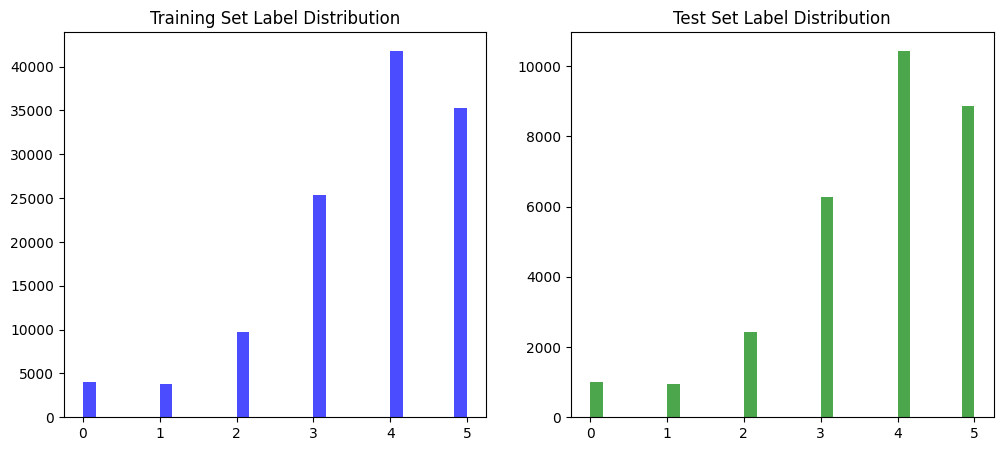

In [ ]:
# На всякий случай посмотрим на распределение таргета в тренировочном и тестовом наборах

def compare_label_distributions(y_train, y_val):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].hist(y_train, bins=30, color='blue', alpha=0.7)
    ax[0].set_title('Training Set Label Distribution')

    ax[1].hist(y_test, bins=30, color='green', alpha=0.7)
    ax[1].set_title('Test Set Label Distribution')

    plt.show()

compare_label_distributions(y_train, y_test)

In [ ]:
# Для удобства работы с LightAutoML

train_data=pd.concat([X_train, y_train], axis=1)
train_data.head()

,review_text,review_text_cleaned,rating
104025,"Like Matched, this book felt like it was echoi...",like matched this book felt like it was echoin...,3
5415,"Money. It's all about the money. I mean, why e...",money it s all about the money i mean why else...,5
75612,This is the first book I have read by the auth...,this is the first book i have read by the auth...,4
138169,5 stars - Vampire Romance \n Great second inst...,5 stars vampire romance great second installme...,5
87184,4 stars \n This is book 2 of the Too Far Serie...,4 stars this is book 2 of the too far series b...,4


### Быстрый вариант решения задачи

В данном подразделе рассмотрим модель со значениями по умолчанию, а также вариант с определением модели для агрегации эмбеддингов слов.

В данном случае мы не занимаемся подбором гиперпараметров для модели.


1. Классический вариант со значениями по умолчанию (единственное: укажем язык, на котором написаны тексты (английский), поскольку по умолчанию ставится русский)

In [ ]:
%%time

automl = TabularNLPAutoML(
    task=Task('multiclass', metric=f1_weighted),
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    gpu_ids = GPU_IDS,
    memory_limit=45, # 45 GB
    text_params={'lang': 'en'}

)

CPU times: user 29.7 ms, sys: 0 ns, total: 29.7 ms
Wall time: 29.2 ms


In [ ]:
%%time

roles = {'target': [TARGET_NAME], 'text' : ['review_text']}
automl.fit_predict(train_data, roles = roles, verbose=100)

[14:42:56] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:42:56] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[14:42:56] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[14:42:56] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:42:56] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[14:42:56] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[14:42:56] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[14:42:56] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[14:42:57] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:42:57] Layer 1 train process start. Time left 198.52 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.52 secs


[14:43:49] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[14:43:49] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


[14:43:49] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:43:49] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:43:49] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:43:50] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:43:51] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:43:52] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:43:52] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:43:52] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:43:52] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:43:53] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:43:53] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:43:53] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:43:53] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


[14:43:53] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:43:53] Time left 142.52 secs



INFO:lightautoml.automl.base:Time left 142.52 secs



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

[14:44:05] Feature concated__review_text fitted


INFO3:lightautoml.transformers.text:Feature concated__review_text fitted


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

100%|██████████| 375/375 [28:24<00:00,  4.55s/it]


[15:12:48] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


[15:12:49] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


[15:12:49] Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


[15:12:50] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[15:12:52] 0:	learn: 1.7678629	test: 1.7680699	best: 1.7680699 (0)	total: 24.5ms	remaining: 1m 37s


INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.7678629	test: 1.7680699	best: 1.7680699 (0)	total: 24.5ms	remaining: 1m 37s


[15:12:53] 100:	learn: 1.2934769	test: 1.3023300	best: 1.3023300 (100)	total: 1.28s	remaining: 49.6s


DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1.2934769	test: 1.3023300	best: 1.3023300 (100)	total: 1.28s	remaining: 49.6s


[15:12:54] 200:	learn: 1.2354536	test: 1.2522022	best: 1.2522022 (200)	total: 2.42s	remaining: 45.8s


DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.2354536	test: 1.2522022	best: 1.2522022 (200)	total: 2.42s	remaining: 45.8s


[15:12:56] 300:	learn: 1.2061588	test: 1.2303752	best: 1.2303752 (300)	total: 3.55s	remaining: 43.6s


DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1.2061588	test: 1.2303752	best: 1.2303752 (300)	total: 3.55s	remaining: 43.6s


[15:12:57] 400:	learn: 1.1867239	test: 1.2184055	best: 1.2184055 (400)	total: 4.67s	remaining: 41.9s


DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1.1867239	test: 1.2184055	best: 1.2184055 (400)	total: 4.67s	remaining: 41.9s


[15:12:58] 500:	learn: 1.1714483	test: 1.2107138	best: 1.2107138 (500)	total: 5.78s	remaining: 40.3s


DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1.1714483	test: 1.2107138	best: 1.2107138 (500)	total: 5.78s	remaining: 40.3s


[15:12:59] 600:	learn: 1.1581546	test: 1.2051073	best: 1.2051073 (600)	total: 6.87s	remaining: 38.9s


DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 1.1581546	test: 1.2051073	best: 1.2051073 (600)	total: 6.87s	remaining: 38.9s


[15:13:00] 700:	learn: 1.1462511	test: 1.2007967	best: 1.2007967 (700)	total: 7.94s	remaining: 37.4s


DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 1.1462511	test: 1.2007967	best: 1.2007967 (700)	total: 7.94s	remaining: 37.4s


[15:13:01] 800:	learn: 1.1353971	test: 1.1971985	best: 1.1971985 (800)	total: 9.03s	remaining: 36.1s


DEBUG:lightautoml.ml_algo.boost_cb:800:	learn: 1.1353971	test: 1.1971985	best: 1.1971985 (800)	total: 9.03s	remaining: 36.1s


[15:13:02] 900:	learn: 1.1251347	test: 1.1941869	best: 1.1941869 (900)	total: 10.1s	remaining: 34.8s


DEBUG:lightautoml.ml_algo.boost_cb:900:	learn: 1.1251347	test: 1.1941869	best: 1.1941869 (900)	total: 10.1s	remaining: 34.8s


[15:13:03] 1000:	learn: 1.1151739	test: 1.1913300	best: 1.1913300 (1000)	total: 11.2s	remaining: 33.6s


DEBUG:lightautoml.ml_algo.boost_cb:1000:	learn: 1.1151739	test: 1.1913300	best: 1.1913300 (1000)	total: 11.2s	remaining: 33.6s


[15:13:04] 1100:	learn: 1.1056533	test: 1.1889706	best: 1.1889706 (1100)	total: 12.3s	remaining: 32.3s


DEBUG:lightautoml.ml_algo.boost_cb:1100:	learn: 1.1056533	test: 1.1889706	best: 1.1889706 (1100)	total: 12.3s	remaining: 32.3s


[15:13:05] 1200:	learn: 1.0965120	test: 1.1870412	best: 1.1870412 (1200)	total: 13.4s	remaining: 31.1s


DEBUG:lightautoml.ml_algo.boost_cb:1200:	learn: 1.0965120	test: 1.1870412	best: 1.1870412 (1200)	total: 13.4s	remaining: 31.1s


[15:13:06] 1300:	learn: 1.0877137	test: 1.1852255	best: 1.1852255 (1300)	total: 14.4s	remaining: 29.9s


DEBUG:lightautoml.ml_algo.boost_cb:1300:	learn: 1.0877137	test: 1.1852255	best: 1.1852255 (1300)	total: 14.4s	remaining: 29.9s


[15:13:08] 1400:	learn: 1.0791360	test: 1.1836729	best: 1.1836729 (1400)	total: 15.5s	remaining: 28.7s


DEBUG:lightautoml.ml_algo.boost_cb:1400:	learn: 1.0791360	test: 1.1836729	best: 1.1836729 (1400)	total: 15.5s	remaining: 28.7s


[15:13:09] 1500:	learn: 1.0707956	test: 1.1820434	best: 1.1820409 (1499)	total: 16.6s	remaining: 27.6s


DEBUG:lightautoml.ml_algo.boost_cb:1500:	learn: 1.0707956	test: 1.1820434	best: 1.1820409 (1499)	total: 16.6s	remaining: 27.6s


[15:13:10] 1600:	learn: 1.0624873	test: 1.1806164	best: 1.1806164 (1600)	total: 17.7s	remaining: 26.5s


DEBUG:lightautoml.ml_algo.boost_cb:1600:	learn: 1.0624873	test: 1.1806164	best: 1.1806164 (1600)	total: 17.7s	remaining: 26.5s


[15:13:11] 1700:	learn: 1.0542430	test: 1.1793011	best: 1.1793011 (1700)	total: 18.7s	remaining: 25.3s


DEBUG:lightautoml.ml_algo.boost_cb:1700:	learn: 1.0542430	test: 1.1793011	best: 1.1793011 (1700)	total: 18.7s	remaining: 25.3s


[15:13:12] 1800:	learn: 1.0462732	test: 1.1779672	best: 1.1779633 (1799)	total: 19.8s	remaining: 24.2s


DEBUG:lightautoml.ml_algo.boost_cb:1800:	learn: 1.0462732	test: 1.1779672	best: 1.1779633 (1799)	total: 19.8s	remaining: 24.2s


[15:13:13] 1900:	learn: 1.0384783	test: 1.1769184	best: 1.1769183 (1899)	total: 20.9s	remaining: 23s


DEBUG:lightautoml.ml_algo.boost_cb:1900:	learn: 1.0384783	test: 1.1769184	best: 1.1769183 (1899)	total: 20.9s	remaining: 23s


[15:13:14] 2000:	learn: 1.0307198	test: 1.1758482	best: 1.1758482 (2000)	total: 21.9s	remaining: 21.9s


DEBUG:lightautoml.ml_algo.boost_cb:2000:	learn: 1.0307198	test: 1.1758482	best: 1.1758482 (2000)	total: 21.9s	remaining: 21.9s


[15:13:15] 2100:	learn: 1.0231741	test: 1.1750482	best: 1.1750482 (2100)	total: 23s	remaining: 20.8s


DEBUG:lightautoml.ml_algo.boost_cb:2100:	learn: 1.0231741	test: 1.1750482	best: 1.1750482 (2100)	total: 23s	remaining: 20.8s


[15:13:16] 2200:	learn: 1.0157171	test: 1.1741161	best: 1.1741161 (2200)	total: 24.1s	remaining: 19.7s


DEBUG:lightautoml.ml_algo.boost_cb:2200:	learn: 1.0157171	test: 1.1741161	best: 1.1741161 (2200)	total: 24.1s	remaining: 19.7s


[15:13:17] 2300:	learn: 1.0084985	test: 1.1732201	best: 1.1732201 (2300)	total: 25.1s	remaining: 18.6s


DEBUG:lightautoml.ml_algo.boost_cb:2300:	learn: 1.0084985	test: 1.1732201	best: 1.1732201 (2300)	total: 25.1s	remaining: 18.6s


[15:13:18] 2400:	learn: 1.0013194	test: 1.1723124	best: 1.1723124 (2400)	total: 26.2s	remaining: 17.4s


DEBUG:lightautoml.ml_algo.boost_cb:2400:	learn: 1.0013194	test: 1.1723124	best: 1.1723124 (2400)	total: 26.2s	remaining: 17.4s


[15:13:19] 2500:	learn: 0.9942974	test: 1.1714894	best: 1.1714894 (2500)	total: 27.3s	remaining: 16.4s


DEBUG:lightautoml.ml_algo.boost_cb:2500:	learn: 0.9942974	test: 1.1714894	best: 1.1714894 (2500)	total: 27.3s	remaining: 16.4s


[15:13:20] 2600:	learn: 0.9872535	test: 1.1707681	best: 1.1707681 (2600)	total: 28.4s	remaining: 15.3s


DEBUG:lightautoml.ml_algo.boost_cb:2600:	learn: 0.9872535	test: 1.1707681	best: 1.1707681 (2600)	total: 28.4s	remaining: 15.3s


[15:13:22] 2700:	learn: 0.9803100	test: 1.1701363	best: 1.1701363 (2700)	total: 29.5s	remaining: 14.2s


DEBUG:lightautoml.ml_algo.boost_cb:2700:	learn: 0.9803100	test: 1.1701363	best: 1.1701363 (2700)	total: 29.5s	remaining: 14.2s


[15:13:23] 2800:	learn: 0.9734298	test: 1.1695656	best: 1.1695656 (2800)	total: 30.5s	remaining: 13.1s


DEBUG:lightautoml.ml_algo.boost_cb:2800:	learn: 0.9734298	test: 1.1695656	best: 1.1695656 (2800)	total: 30.5s	remaining: 13.1s


[15:13:24] 2900:	learn: 0.9667355	test: 1.1689519	best: 1.1689519 (2900)	total: 31.6s	remaining: 12s


DEBUG:lightautoml.ml_algo.boost_cb:2900:	learn: 0.9667355	test: 1.1689519	best: 1.1689519 (2900)	total: 31.6s	remaining: 12s


[15:13:25] 3000:	learn: 0.9599970	test: 1.1684245	best: 1.1684245 (3000)	total: 32.7s	remaining: 10.9s


DEBUG:lightautoml.ml_algo.boost_cb:3000:	learn: 0.9599970	test: 1.1684245	best: 1.1684245 (3000)	total: 32.7s	remaining: 10.9s


[15:13:26] 3100:	learn: 0.9532979	test: 1.1679386	best: 1.1679386 (3100)	total: 33.8s	remaining: 9.8s


DEBUG:lightautoml.ml_algo.boost_cb:3100:	learn: 0.9532979	test: 1.1679386	best: 1.1679386 (3100)	total: 33.8s	remaining: 9.8s


[15:13:27] 3200:	learn: 0.9467872	test: 1.1673938	best: 1.1673938 (3200)	total: 34.9s	remaining: 8.71s


DEBUG:lightautoml.ml_algo.boost_cb:3200:	learn: 0.9467872	test: 1.1673938	best: 1.1673938 (3200)	total: 34.9s	remaining: 8.71s


[15:13:28] 3300:	learn: 0.9401509	test: 1.1669726	best: 1.1669595 (3292)	total: 36s	remaining: 7.62s


DEBUG:lightautoml.ml_algo.boost_cb:3300:	learn: 0.9401509	test: 1.1669726	best: 1.1669595 (3292)	total: 36s	remaining: 7.62s


[15:13:29] 3400:	learn: 0.9336406	test: 1.1664531	best: 1.1664531 (3400)	total: 37.1s	remaining: 6.53s


DEBUG:lightautoml.ml_algo.boost_cb:3400:	learn: 0.9336406	test: 1.1664531	best: 1.1664531 (3400)	total: 37.1s	remaining: 6.53s


[15:13:30] 3500:	learn: 0.9273119	test: 1.1660744	best: 1.1660744 (3500)	total: 38.2s	remaining: 5.44s


DEBUG:lightautoml.ml_algo.boost_cb:3500:	learn: 0.9273119	test: 1.1660744	best: 1.1660744 (3500)	total: 38.2s	remaining: 5.44s


[15:13:31] 3600:	learn: 0.9210709	test: 1.1656370	best: 1.1656334 (3599)	total: 39.3s	remaining: 4.35s


DEBUG:lightautoml.ml_algo.boost_cb:3600:	learn: 0.9210709	test: 1.1656370	best: 1.1656334 (3599)	total: 39.3s	remaining: 4.35s


[15:13:32] 3700:	learn: 0.9148550	test: 1.1651337	best: 1.1651310 (3699)	total: 40.3s	remaining: 3.26s


DEBUG:lightautoml.ml_algo.boost_cb:3700:	learn: 0.9148550	test: 1.1651337	best: 1.1651310 (3699)	total: 40.3s	remaining: 3.26s


[15:13:34] 3800:	learn: 0.9087444	test: 1.1646960	best: 1.1646960 (3800)	total: 41.4s	remaining: 2.17s


DEBUG:lightautoml.ml_algo.boost_cb:3800:	learn: 0.9087444	test: 1.1646960	best: 1.1646960 (3800)	total: 41.4s	remaining: 2.17s


[15:13:35] 3900:	learn: 0.9026343	test: 1.1644247	best: 1.1644246 (3898)	total: 42.5s	remaining: 1.08s


DEBUG:lightautoml.ml_algo.boost_cb:3900:	learn: 0.9026343	test: 1.1644247	best: 1.1644246 (3898)	total: 42.5s	remaining: 1.08s


[15:13:36] 3999:	learn: 0.8966476	test: 1.1641029	best: 1.1640915 (3985)	total: 43.5s	remaining: 0us


DEBUG:lightautoml.ml_algo.boost_cb:3999:	learn: 0.8966476	test: 1.1641029	best: 1.1640915 (3985)	total: 43.5s	remaining: 0us


[15:13:36] bestTest = 1.164091504


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.164091504


[15:13:36] bestIteration = 3985


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 3985


[15:13:36] Shrink model to first 3986 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 3986 iterations.


[15:13:36] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[15:13:36] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.4840714542497537


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.4840714542497537


[15:13:36] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[15:13:36] Time left -1640.68 secs



INFO:lightautoml.automl.base:Time left -1640.68 secs



[15:13:36] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[15:13:36] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:13:36] Blending: optimization starts with equal weights and score 0.3044932442092449


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.3044932442092449


[15:13:37] Blending: iteration 0: score = 0.4840714542497537, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.4840714542497537, weights = [0. 1.]


[15:13:37] Blending: iteration 1: score = 0.4840714542497537, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.4840714542497537, weights = [0. 1.]


[15:13:37] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[15:13:37] Automl preset training completed in 1841.55 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1841.55 seconds



[15:13:37] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 33min 42s, sys: 49.7 s, total: 34min 31s
Wall time: 30min 41s


array([[0.00163104, 0.00161634, 0.02808766, 0.38148236, 0.49234873,
        0.09483386],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [0.01409889, 0.00136617, 0.01333405, 0.10299289, 0.4531605 ,
        0.4150475 ],
       ...,
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)
print(f"f1_score is {f1_weighted(y_test['rating'], predictions.data)}")

100%|██████████| 94/94 [07:05<00:00,  4.53s/it]


[15:21:06] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


f1_score is 0.4869919948968139


Получили очень хороший f1_score (~ топ-169) за ~ 40 минут

2. Рассмотрим вариант с выбором модели агрегации эмбеддингов (рассмотрим BOREP и LSTM).

В отличие от первого варианта, функционирующем на основе использования предобученных моделей, BOREP и RandomLSTM выполняются быстрее.

In [ ]:
%%time

automl = TabularNLPAutoML(
    task=Task('multiclass', metric=f1_weighted),
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    gpu_ids = GPU_IDS,
    memory_limit=45, # 45 GB
    autonlp_params = {
        'model_name' : 'borep'
    },
    text_params={'lang': 'en'}
)

CPU times: user 32.1 ms, sys: 1.62 ms, total: 33.7 ms
Wall time: 33.1 ms


In [ ]:
%%time

roles = {'target': [TARGET_NAME], 'text' : ['review_text']}
automl.fit_predict(train_data, roles = roles, verbose=100)

[14:38:29] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:38:29] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[14:38:29] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[14:38:29] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:38:29] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[14:38:29] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[14:38:29] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[14:38:29] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[14:38:30] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:38:30] Layer 1 train process start. Time left 198.50 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.50 secs


[14:39:22] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[14:39:22] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


[14:39:22] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:39:23] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:39:23] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:39:23] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:39:23] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:39:23] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:39:24] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:39:24] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:39:24] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:39:24] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:39:24] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:39:24] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:39:25] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


[14:39:25] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:39:25] Time left 144.28 secs



INFO:lightautoml.automl.base:Time left 144.28 secs



[14:41:37] Feature concated__review_text fitted


INFO3:lightautoml.transformers.text:Feature concated__review_text fitted
100%|██████████| 118/118 [00:23<00:00,  5.00it/s]


[14:42:02] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


[14:42:02] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


[14:42:02] Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


[14:42:03] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[14:42:04] 0:	learn: 1.7738852	test: 1.7739885	best: 1.7739885 (0)	total: 14.3ms	remaining: 57.2s


INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.7738852	test: 1.7739885	best: 1.7739885 (0)	total: 14.3ms	remaining: 57.2s


[14:42:04] 100:	learn: 1.4552121	test: 1.4627374	best: 1.4627374 (100)	total: 747ms	remaining: 28.8s


DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1.4552121	test: 1.4627374	best: 1.4627374 (100)	total: 747ms	remaining: 28.8s


[14:42:05] 200:	learn: 1.4418655	test: 1.4561994	best: 1.4561994 (200)	total: 1.35s	remaining: 25.4s


DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.4418655	test: 1.4561994	best: 1.4561994 (200)	total: 1.35s	remaining: 25.4s


[14:42:06] 300:	learn: 1.4327143	test: 1.4538107	best: 1.4538107 (300)	total: 1.94s	remaining: 23.9s


DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1.4327143	test: 1.4538107	best: 1.4538107 (300)	total: 1.94s	remaining: 23.9s


[14:42:06] 400:	learn: 1.4247216	test: 1.4523364	best: 1.4523364 (400)	total: 2.55s	remaining: 22.9s


DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1.4247216	test: 1.4523364	best: 1.4523364 (400)	total: 2.55s	remaining: 22.9s


[14:42:07] 500:	learn: 1.4174505	test: 1.4513016	best: 1.4513016 (500)	total: 3.16s	remaining: 22.1s


DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1.4174505	test: 1.4513016	best: 1.4513016 (500)	total: 3.16s	remaining: 22.1s


[14:42:07] 600:	learn: 1.4102491	test: 1.4504433	best: 1.4504243 (599)	total: 3.77s	remaining: 21.3s


DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 1.4102491	test: 1.4504433	best: 1.4504243 (599)	total: 3.77s	remaining: 21.3s


[14:42:08] 700:	learn: 1.4035752	test: 1.4499449	best: 1.4499357 (699)	total: 4.38s	remaining: 20.6s


DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 1.4035752	test: 1.4499449	best: 1.4499357 (699)	total: 4.38s	remaining: 20.6s


[14:42:09] 800:	learn: 1.3970715	test: 1.4494274	best: 1.4494274 (800)	total: 4.99s	remaining: 19.9s


DEBUG:lightautoml.ml_algo.boost_cb:800:	learn: 1.3970715	test: 1.4494274	best: 1.4494274 (800)	total: 4.99s	remaining: 19.9s


[14:42:09] 900:	learn: 1.3908629	test: 1.4490555	best: 1.4490555 (900)	total: 5.59s	remaining: 19.2s


DEBUG:lightautoml.ml_algo.boost_cb:900:	learn: 1.3908629	test: 1.4490555	best: 1.4490555 (900)	total: 5.59s	remaining: 19.2s


[14:42:10] 1000:	learn: 1.3847385	test: 1.4486229	best: 1.4486229 (1000)	total: 6.21s	remaining: 18.6s


DEBUG:lightautoml.ml_algo.boost_cb:1000:	learn: 1.3847385	test: 1.4486229	best: 1.4486229 (1000)	total: 6.21s	remaining: 18.6s


[14:42:10] 1100:	learn: 1.3788463	test: 1.4482684	best: 1.4482418 (1097)	total: 6.81s	remaining: 17.9s


DEBUG:lightautoml.ml_algo.boost_cb:1100:	learn: 1.3788463	test: 1.4482684	best: 1.4482418 (1097)	total: 6.81s	remaining: 17.9s


[14:42:11] 1200:	learn: 1.3728771	test: 1.4480651	best: 1.4480651 (1200)	total: 7.44s	remaining: 17.3s


DEBUG:lightautoml.ml_algo.boost_cb:1200:	learn: 1.3728771	test: 1.4480651	best: 1.4480651 (1200)	total: 7.44s	remaining: 17.3s


[14:42:12] 1300:	learn: 1.3669714	test: 1.4477053	best: 1.4476966 (1298)	total: 8.05s	remaining: 16.7s


DEBUG:lightautoml.ml_algo.boost_cb:1300:	learn: 1.3669714	test: 1.4477053	best: 1.4476966 (1298)	total: 8.05s	remaining: 16.7s


[14:42:12] 1400:	learn: 1.3614521	test: 1.4475195	best: 1.4475195 (1400)	total: 8.67s	remaining: 16.1s


DEBUG:lightautoml.ml_algo.boost_cb:1400:	learn: 1.3614521	test: 1.4475195	best: 1.4475195 (1400)	total: 8.67s	remaining: 16.1s


[14:42:13] 1500:	learn: 1.3559041	test: 1.4473739	best: 1.4473457 (1493)	total: 9.28s	remaining: 15.5s


DEBUG:lightautoml.ml_algo.boost_cb:1500:	learn: 1.3559041	test: 1.4473739	best: 1.4473457 (1493)	total: 9.28s	remaining: 15.5s


[14:42:14] 1600:	learn: 1.3505116	test: 1.4472787	best: 1.4472548 (1586)	total: 9.88s	remaining: 14.8s


DEBUG:lightautoml.ml_algo.boost_cb:1600:	learn: 1.3505116	test: 1.4472787	best: 1.4472548 (1586)	total: 9.88s	remaining: 14.8s


[14:42:14] 1700:	learn: 1.3451813	test: 1.4470854	best: 1.4470638 (1684)	total: 10.5s	remaining: 14.2s


DEBUG:lightautoml.ml_algo.boost_cb:1700:	learn: 1.3451813	test: 1.4470854	best: 1.4470638 (1684)	total: 10.5s	remaining: 14.2s


[14:42:15] 1800:	learn: 1.3399278	test: 1.4469920	best: 1.4469879 (1798)	total: 11.1s	remaining: 13.6s


DEBUG:lightautoml.ml_algo.boost_cb:1800:	learn: 1.3399278	test: 1.4469920	best: 1.4469879 (1798)	total: 11.1s	remaining: 13.6s


[14:42:15] 1900:	learn: 1.3347312	test: 1.4469546	best: 1.4469328 (1891)	total: 11.7s	remaining: 13s


DEBUG:lightautoml.ml_algo.boost_cb:1900:	learn: 1.3347312	test: 1.4469546	best: 1.4469328 (1891)	total: 11.7s	remaining: 13s


[14:42:16] 2000:	learn: 1.3296842	test: 1.4469217	best: 1.4469039 (1997)	total: 12.3s	remaining: 12.3s


DEBUG:lightautoml.ml_algo.boost_cb:2000:	learn: 1.3296842	test: 1.4469217	best: 1.4469039 (1997)	total: 12.3s	remaining: 12.3s


[14:42:17] bestTest = 1.446903906


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.446903906


[14:42:17] bestIteration = 1997


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 1997


[14:42:17] Shrink model to first 1998 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 1998 iterations.


[14:42:17] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:42:17] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.2980276989017518


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.2980276989017518


[14:42:17] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[14:42:17] Time left -28.19 secs



INFO:lightautoml.automl.base:Time left -28.19 secs



[14:42:17] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[14:42:17] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:42:17] Blending: optimization starts with equal weights and score 0.21606498891960849


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.21606498891960849


[14:42:17] Blending: iteration 0: score = 0.2980276989017518, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.2980276989017518, weights = [0. 1.]


[14:42:18] Blending: iteration 1: score = 0.2980276989017518, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.2980276989017518, weights = [0. 1.]


[14:42:18] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:42:18] Automl preset training completed in 228.99 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 228.99 seconds



[14:42:18] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 5min 57s, sys: 32.1 s, total: 6min 30s
Wall time: 3min 49s


array([[0.03110255, 0.02492913, 0.06944723, 0.3103426 , 0.36513034,
        0.19904815],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [0.05069344, 0.03944595, 0.10368769, 0.1963189 , 0.2911189 ,
        0.31873512],
       ...,
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)
print(f"f1_score is {f1_weighted(y_test['rating'], predictions.data)}")

100%|██████████| 30/30 [00:07<00:00,  4.14it/s]


[14:42:34] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


f1_score is 0.29983389225868246


In [ ]:
%%time

automl = TabularNLPAutoML(
    task=Task('multiclass', metric=f1_weighted),
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    gpu_ids = GPU_IDS,
    memory_limit=45, # 45 GB
    autonlp_params = {
        'model_name' : 'random_lstm'
    },
    text_params={'lang': 'en'}
)

CPU times: user 29.3 ms, sys: 2.01 ms, total: 31.3 ms
Wall time: 30.9 ms


In [ ]:
%%time

roles = {'target': [TARGET_NAME], 'text' : ['review_text']}
automl.fit_predict(train_data, roles = roles, verbose=100)

[14:32:00] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[14:32:00] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[14:32:00] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[14:32:00] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[14:32:00] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[14:32:00] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[14:32:00] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[14:32:00] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[14:32:02] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[14:32:02] Layer 1 train process start. Time left 198.61 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.61 secs


[14:32:53] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[14:32:53] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


[14:32:53] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:32:53] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:32:53] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:32:54] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:32:55] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:32:56] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:32:56] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:32:56] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:32:56] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[14:32:57] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[14:32:57] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[14:32:57] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[14:32:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


[14:32:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[14:32:57] Time left 143.26 secs



INFO:lightautoml.automl.base:Time left 143.26 secs



[14:35:13] Feature concated__review_text fitted


INFO3:lightautoml.transformers.text:Feature concated__review_text fitted
100%|██████████| 118/118 [00:27<00:00,  4.24it/s]


[14:35:42] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


[14:35:43] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


[14:35:43] Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


[14:35:43] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[14:35:45] 0:	learn: 1.7737682	test: 1.7738660	best: 1.7738660 (0)	total: 27.2ms	remaining: 1m 48s


INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.7737682	test: 1.7738660	best: 1.7738660 (0)	total: 27.2ms	remaining: 1m 48s


[14:35:46] 100:	learn: 1.4471637	test: 1.4556967	best: 1.4556967 (100)	total: 972ms	remaining: 37.5s


DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1.4471637	test: 1.4556967	best: 1.4556967 (100)	total: 972ms	remaining: 37.5s


[14:35:47] 200:	learn: 1.4301422	test: 1.4464536	best: 1.4464536 (200)	total: 1.79s	remaining: 33.8s


DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.4301422	test: 1.4464536	best: 1.4464536 (200)	total: 1.79s	remaining: 33.8s


[14:35:48] 300:	learn: 1.4187771	test: 1.4424162	best: 1.4424162 (300)	total: 2.6s	remaining: 31.9s


DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1.4187771	test: 1.4424162	best: 1.4424162 (300)	total: 2.6s	remaining: 31.9s


[14:35:49] 400:	learn: 1.4090748	test: 1.4399556	best: 1.4399556 (400)	total: 3.41s	remaining: 30.6s


DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1.4090748	test: 1.4399556	best: 1.4399556 (400)	total: 3.41s	remaining: 30.6s


[14:35:49] 500:	learn: 1.4003880	test: 1.4380710	best: 1.4380710 (500)	total: 4.22s	remaining: 29.5s


DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1.4003880	test: 1.4380710	best: 1.4380710 (500)	total: 4.22s	remaining: 29.5s


[14:35:50] 600:	learn: 1.3919982	test: 1.4366515	best: 1.4366515 (600)	total: 5.04s	remaining: 28.5s


DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 1.3919982	test: 1.4366515	best: 1.4366515 (600)	total: 5.04s	remaining: 28.5s


[14:35:51] 700:	learn: 1.3841118	test: 1.4354329	best: 1.4354329 (700)	total: 5.84s	remaining: 27.5s


DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 1.3841118	test: 1.4354329	best: 1.4354329 (700)	total: 5.84s	remaining: 27.5s


[14:35:52] 800:	learn: 1.3766412	test: 1.4345865	best: 1.4345840 (799)	total: 6.65s	remaining: 26.6s


DEBUG:lightautoml.ml_algo.boost_cb:800:	learn: 1.3766412	test: 1.4345865	best: 1.4345840 (799)	total: 6.65s	remaining: 26.6s


[14:35:53] 900:	learn: 1.3694698	test: 1.4337056	best: 1.4337056 (900)	total: 7.46s	remaining: 25.6s


DEBUG:lightautoml.ml_algo.boost_cb:900:	learn: 1.3694698	test: 1.4337056	best: 1.4337056 (900)	total: 7.46s	remaining: 25.6s


[14:35:54] 1000:	learn: 1.3624532	test: 1.4329409	best: 1.4329409 (1000)	total: 8.26s	remaining: 24.8s


DEBUG:lightautoml.ml_algo.boost_cb:1000:	learn: 1.3624532	test: 1.4329409	best: 1.4329409 (1000)	total: 8.26s	remaining: 24.8s


[14:35:54] 1100:	learn: 1.3556237	test: 1.4323733	best: 1.4323733 (1100)	total: 9.07s	remaining: 23.9s


DEBUG:lightautoml.ml_algo.boost_cb:1100:	learn: 1.3556237	test: 1.4323733	best: 1.4323733 (1100)	total: 9.07s	remaining: 23.9s


[14:35:55] 1200:	learn: 1.3488661	test: 1.4317282	best: 1.4317282 (1200)	total: 9.9s	remaining: 23.1s


DEBUG:lightautoml.ml_algo.boost_cb:1200:	learn: 1.3488661	test: 1.4317282	best: 1.4317282 (1200)	total: 9.9s	remaining: 23.1s


[14:35:56] 1300:	learn: 1.3425484	test: 1.4313777	best: 1.4313674 (1293)	total: 10.7s	remaining: 22.2s


DEBUG:lightautoml.ml_algo.boost_cb:1300:	learn: 1.3425484	test: 1.4313777	best: 1.4313674 (1293)	total: 10.7s	remaining: 22.2s


[14:35:57] 1400:	learn: 1.3360987	test: 1.4309396	best: 1.4309396 (1400)	total: 11.5s	remaining: 21.4s


DEBUG:lightautoml.ml_algo.boost_cb:1400:	learn: 1.3360987	test: 1.4309396	best: 1.4309396 (1400)	total: 11.5s	remaining: 21.4s


[14:35:58] 1500:	learn: 1.3297494	test: 1.4304183	best: 1.4304166 (1494)	total: 12.4s	remaining: 20.6s


DEBUG:lightautoml.ml_algo.boost_cb:1500:	learn: 1.3297494	test: 1.4304183	best: 1.4304166 (1494)	total: 12.4s	remaining: 20.6s


[14:35:58] 1600:	learn: 1.3235669	test: 1.4300133	best: 1.4299979 (1597)	total: 13.2s	remaining: 19.7s


DEBUG:lightautoml.ml_algo.boost_cb:1600:	learn: 1.3235669	test: 1.4300133	best: 1.4299979 (1597)	total: 13.2s	remaining: 19.7s


[14:35:59] 1700:	learn: 1.3175292	test: 1.4296955	best: 1.4296941 (1699)	total: 14s	remaining: 18.9s


DEBUG:lightautoml.ml_algo.boost_cb:1700:	learn: 1.3175292	test: 1.4296955	best: 1.4296941 (1699)	total: 14s	remaining: 18.9s


[14:36:00] 1800:	learn: 1.3114213	test: 1.4293611	best: 1.4293553 (1799)	total: 14.8s	remaining: 18.1s


DEBUG:lightautoml.ml_algo.boost_cb:1800:	learn: 1.3114213	test: 1.4293611	best: 1.4293553 (1799)	total: 14.8s	remaining: 18.1s


[14:36:01] 1900:	learn: 1.3054642	test: 1.4289471	best: 1.4289409 (1899)	total: 15.6s	remaining: 17.3s


DEBUG:lightautoml.ml_algo.boost_cb:1900:	learn: 1.3054642	test: 1.4289471	best: 1.4289409 (1899)	total: 15.6s	remaining: 17.3s


[14:36:02] 2000:	learn: 1.2995320	test: 1.4286796	best: 1.4286762 (1979)	total: 16.5s	remaining: 16.4s


DEBUG:lightautoml.ml_algo.boost_cb:2000:	learn: 1.2995320	test: 1.4286796	best: 1.4286762 (1979)	total: 16.5s	remaining: 16.4s


[14:36:03] 2100:	learn: 1.2937266	test: 1.4284853	best: 1.4284347 (2086)	total: 17.3s	remaining: 15.6s


DEBUG:lightautoml.ml_algo.boost_cb:2100:	learn: 1.2937266	test: 1.4284853	best: 1.4284347 (2086)	total: 17.3s	remaining: 15.6s


[14:36:03] 2200:	learn: 1.2880533	test: 1.4282565	best: 1.4282441 (2199)	total: 18.1s	remaining: 14.8s


DEBUG:lightautoml.ml_algo.boost_cb:2200:	learn: 1.2880533	test: 1.4282565	best: 1.4282441 (2199)	total: 18.1s	remaining: 14.8s


[14:36:04] 2300:	learn: 1.2824648	test: 1.4280927	best: 1.4280651 (2296)	total: 18.9s	remaining: 14s


DEBUG:lightautoml.ml_algo.boost_cb:2300:	learn: 1.2824648	test: 1.4280927	best: 1.4280651 (2296)	total: 18.9s	remaining: 14s


[14:36:05] 2400:	learn: 1.2768489	test: 1.4278500	best: 1.4278064 (2391)	total: 19.7s	remaining: 13.1s


DEBUG:lightautoml.ml_algo.boost_cb:2400:	learn: 1.2768489	test: 1.4278500	best: 1.4278064 (2391)	total: 19.7s	remaining: 13.1s


[14:36:06] 2500:	learn: 1.2714342	test: 1.4278051	best: 1.4277944 (2494)	total: 20.5s	remaining: 12.3s


DEBUG:lightautoml.ml_algo.boost_cb:2500:	learn: 1.2714342	test: 1.4278051	best: 1.4277944 (2494)	total: 20.5s	remaining: 12.3s


[14:36:07] 2600:	learn: 1.2660530	test: 1.4277069	best: 1.4276894 (2595)	total: 21.3s	remaining: 11.5s


DEBUG:lightautoml.ml_algo.boost_cb:2600:	learn: 1.2660530	test: 1.4277069	best: 1.4276894 (2595)	total: 21.3s	remaining: 11.5s


[14:36:07] 2700:	learn: 1.2606745	test: 1.4276988	best: 1.4276741 (2692)	total: 22.2s	remaining: 10.7s


DEBUG:lightautoml.ml_algo.boost_cb:2700:	learn: 1.2606745	test: 1.4276988	best: 1.4276741 (2692)	total: 22.2s	remaining: 10.7s


[14:36:08] 2800:	learn: 1.2552169	test: 1.4277157	best: 1.4276438 (2765)	total: 23s	remaining: 9.83s


DEBUG:lightautoml.ml_algo.boost_cb:2800:	learn: 1.2552169	test: 1.4277157	best: 1.4276438 (2765)	total: 23s	remaining: 9.83s


[14:36:09] bestTest = 1.42764375


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.42764375


[14:36:09] bestIteration = 2765


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 2765


[14:36:09] Shrink model to first 2766 iterations.


INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 2766 iterations.


[14:36:09] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:36:09] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.3264685451984004


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.3264685451984004


[14:36:09] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[14:36:09] Time left -48.89 secs



INFO:lightautoml.automl.base:Time left -48.89 secs



[14:36:09] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[14:36:09] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:36:09] Blending: optimization starts with equal weights and score 0.22463491597248733


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.22463491597248733


[14:36:10] Blending: iteration 0: score = 0.3264685451984004, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.3264685451984004, weights = [0. 1.]


[14:36:10] Blending: iteration 1: score = 0.3264685451984004, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.3264685451984004, weights = [0. 1.]


[14:36:10] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[14:36:10] Automl preset training completed in 249.70 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 249.70 seconds



[14:36:10] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 6min 44s, sys: 40 s, total: 7min 24s
Wall time: 4min 9s


array([[0.01934675, 0.01720879, 0.06713362, 0.36797687, 0.36105847,
        0.1672755 ],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [0.03903079, 0.03539817, 0.08518661, 0.2343368 , 0.29835624,
        0.3076914 ],
       ...,
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)
print(f"f1_score is {f1_weighted(y_test['rating'], predictions.data)}")

100%|██████████| 30/30 [00:07<00:00,  4.03it/s]


[14:37:47] Feature concated__review_text transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text transformed


f1_score is 0.3259396487571955


Агрегация через BOREP и RandomLSTM хоть и выполняется быстрее, но показывает более слабый результат. Использование предобученных моделей дает более высокий результат по сравнению с обучением fastText на корпусе.

### Быстрый вариант решения задачи c препроцессингом текста

В данном случае ключевым отличием станет использования обработанного текста (колонка ```review_text_cleaned```). В качестве модели возьмем дефолтную. Все параметры внутри TabularNLPAutoML остаются неизменными.

In [ ]:
%%time

automl = TabularNLPAutoML(
    task=Task('multiclass', metric=f1_weighted),
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    gpu_ids = GPU_IDS,
    memory_limit=45, # 45 GB
    text_params={'lang': 'en'}

)

In [ ]:
%%time

roles = {'target': [TARGET_NAME], 'text' : ['review_text_cleaned']}
automl.fit_predict(train_data, roles = roles, verbose=100)

[15:25:06] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[15:25:06] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[15:25:06] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[15:25:06] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:25:06] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[15:25:06] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[15:25:06] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[15:25:06] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[15:25:07] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[15:25:07] Layer 1 train process start. Time left 198.32 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.32 secs


[15:26:01] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[15:26:01] Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 101}


[15:26:01] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:26:02] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[15:26:02] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[15:26:02] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[15:26:02] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:26:02] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[15:26:03] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[15:26:03] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[15:26:03] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


[15:26:03] Linear model: C = 1e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = 0.180219427554501


[15:26:03] Linear model: C = 5e-05 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = 0.180219427554501


[15:26:04] Linear model: C = 0.0001 score = 0.180219427554501


INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = 0.180219427554501


[15:26:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.180219427554501


[15:26:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[15:26:04] Time left 142.15 secs



INFO:lightautoml.automl.base:Time left 142.15 secs



[15:26:08] Feature concated__review_text_cleaned fitted


INFO3:lightautoml.transformers.text:Feature concated__review_text_cleaned fitted
100%|██████████| 375/375 [28:20<00:00,  4.54s/it]


[15:54:33] Feature concated__review_text_cleaned transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text_cleaned transformed


[15:54:34] Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_CatBoost ...


[15:54:34] Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'GPU', 'thread_count': 8, 'random_seed': 42, 'num_trees': 4000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'devices': '0'}


[15:54:35] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_CatBoost =====


[15:54:37] 0:	learn: 1.7688195	test: 1.7690570	best: 1.7690570 (0)	total: 24.2ms	remaining: 1m 36s


INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.7688195	test: 1.7690570	best: 1.7690570 (0)	total: 24.2ms	remaining: 1m 36s


[15:54:38] 100:	learn: 1.3082459	test: 1.3151457	best: 1.3151457 (100)	total: 1.29s	remaining: 50s


DEBUG:lightautoml.ml_algo.boost_cb:100:	learn: 1.3082459	test: 1.3151457	best: 1.3151457 (100)	total: 1.29s	remaining: 50s


[15:54:39] 200:	learn: 1.2541728	test: 1.2676087	best: 1.2676087 (200)	total: 2.44s	remaining: 46.1s


DEBUG:lightautoml.ml_algo.boost_cb:200:	learn: 1.2541728	test: 1.2676087	best: 1.2676087 (200)	total: 2.44s	remaining: 46.1s


[15:54:40] 300:	learn: 1.2269588	test: 1.2474129	best: 1.2474129 (300)	total: 3.58s	remaining: 44s


DEBUG:lightautoml.ml_algo.boost_cb:300:	learn: 1.2269588	test: 1.2474129	best: 1.2474129 (300)	total: 3.58s	remaining: 44s


[15:54:42] 400:	learn: 1.2081070	test: 1.2359639	best: 1.2359639 (400)	total: 4.7s	remaining: 42.2s


DEBUG:lightautoml.ml_algo.boost_cb:400:	learn: 1.2081070	test: 1.2359639	best: 1.2359639 (400)	total: 4.7s	remaining: 42.2s


[15:54:43] 500:	learn: 1.1928246	test: 1.2279256	best: 1.2279256 (500)	total: 5.83s	remaining: 40.7s


DEBUG:lightautoml.ml_algo.boost_cb:500:	learn: 1.1928246	test: 1.2279256	best: 1.2279256 (500)	total: 5.83s	remaining: 40.7s


[15:54:44] 600:	learn: 1.1796306	test: 1.2223884	best: 1.2223884 (600)	total: 6.92s	remaining: 39.2s


DEBUG:lightautoml.ml_algo.boost_cb:600:	learn: 1.1796306	test: 1.2223884	best: 1.2223884 (600)	total: 6.92s	remaining: 39.2s


[15:54:45] 700:	learn: 1.1674594	test: 1.2176747	best: 1.2176747 (700)	total: 8.04s	remaining: 37.8s


DEBUG:lightautoml.ml_algo.boost_cb:700:	learn: 1.1674594	test: 1.2176747	best: 1.2176747 (700)	total: 8.04s	remaining: 37.8s


[15:54:46] 800:	learn: 1.1562852	test: 1.2139675	best: 1.2139675 (800)	total: 9.12s	remaining: 36.4s


DEBUG:lightautoml.ml_algo.boost_cb:800:	learn: 1.1562852	test: 1.2139675	best: 1.2139675 (800)	total: 9.12s	remaining: 36.4s


[15:54:47] 900:	learn: 1.1457245	test: 1.2106556	best: 1.2106556 (900)	total: 10.2s	remaining: 35.2s


DEBUG:lightautoml.ml_algo.boost_cb:900:	learn: 1.1457245	test: 1.2106556	best: 1.2106556 (900)	total: 10.2s	remaining: 35.2s


[15:54:48] 1000:	learn: 1.1356090	test: 1.2079754	best: 1.2079754 (1000)	total: 11.3s	remaining: 33.9s


DEBUG:lightautoml.ml_algo.boost_cb:1000:	learn: 1.1356090	test: 1.2079754	best: 1.2079754 (1000)	total: 11.3s	remaining: 33.9s


[15:54:49] 1100:	learn: 1.1259107	test: 1.2054311	best: 1.2054311 (1100)	total: 12.4s	remaining: 32.6s


DEBUG:lightautoml.ml_algo.boost_cb:1100:	learn: 1.1259107	test: 1.2054311	best: 1.2054311 (1100)	total: 12.4s	remaining: 32.6s


[15:54:50] 1200:	learn: 1.1166118	test: 1.2032894	best: 1.2032894 (1200)	total: 13.5s	remaining: 31.4s


DEBUG:lightautoml.ml_algo.boost_cb:1200:	learn: 1.1166118	test: 1.2032894	best: 1.2032894 (1200)	total: 13.5s	remaining: 31.4s


[15:54:51] 1300:	learn: 1.1075743	test: 1.2012521	best: 1.2012521 (1300)	total: 14.6s	remaining: 30.2s


DEBUG:lightautoml.ml_algo.boost_cb:1300:	learn: 1.1075743	test: 1.2012521	best: 1.2012521 (1300)	total: 14.6s	remaining: 30.2s


[15:54:53] 1400:	learn: 1.0987723	test: 1.1996043	best: 1.1996043 (1400)	total: 15.7s	remaining: 29.1s


DEBUG:lightautoml.ml_algo.boost_cb:1400:	learn: 1.0987723	test: 1.1996043	best: 1.1996043 (1400)	total: 15.7s	remaining: 29.1s


[15:54:54] 1500:	learn: 1.0903042	test: 1.1980724	best: 1.1980724 (1500)	total: 16.7s	remaining: 27.9s


DEBUG:lightautoml.ml_algo.boost_cb:1500:	learn: 1.0903042	test: 1.1980724	best: 1.1980724 (1500)	total: 16.7s	remaining: 27.9s


[15:54:55] 1600:	learn: 1.0819146	test: 1.1967515	best: 1.1967515 (1600)	total: 17.8s	remaining: 26.7s


DEBUG:lightautoml.ml_algo.boost_cb:1600:	learn: 1.0819146	test: 1.1967515	best: 1.1967515 (1600)	total: 17.8s	remaining: 26.7s


[15:54:56] 1700:	learn: 1.0738859	test: 1.1954099	best: 1.1954099 (1700)	total: 18.9s	remaining: 25.5s


DEBUG:lightautoml.ml_algo.boost_cb:1700:	learn: 1.0738859	test: 1.1954099	best: 1.1954099 (1700)	total: 18.9s	remaining: 25.5s


[15:54:57] 1800:	learn: 1.0659233	test: 1.1942341	best: 1.1942249 (1799)	total: 20s	remaining: 24.4s


DEBUG:lightautoml.ml_algo.boost_cb:1800:	learn: 1.0659233	test: 1.1942341	best: 1.1942249 (1799)	total: 20s	remaining: 24.4s


[15:54:58] 1900:	learn: 1.0580608	test: 1.1930975	best: 1.1930975 (1900)	total: 21s	remaining: 23.2s


DEBUG:lightautoml.ml_algo.boost_cb:1900:	learn: 1.0580608	test: 1.1930975	best: 1.1930975 (1900)	total: 21s	remaining: 23.2s


[15:54:59] 2000:	learn: 1.0503219	test: 1.1922198	best: 1.1922198 (2000)	total: 22.1s	remaining: 22.1s


DEBUG:lightautoml.ml_algo.boost_cb:2000:	learn: 1.0503219	test: 1.1922198	best: 1.1922198 (2000)	total: 22.1s	remaining: 22.1s


[15:55:00] 2100:	learn: 1.0426622	test: 1.1910983	best: 1.1910983 (2100)	total: 23.2s	remaining: 21s


DEBUG:lightautoml.ml_algo.boost_cb:2100:	learn: 1.0426622	test: 1.1910983	best: 1.1910983 (2100)	total: 23.2s	remaining: 21s


[15:55:01] 2200:	learn: 1.0350086	test: 1.1900796	best: 1.1900796 (2200)	total: 24.3s	remaining: 19.8s


DEBUG:lightautoml.ml_algo.boost_cb:2200:	learn: 1.0350086	test: 1.1900796	best: 1.1900796 (2200)	total: 24.3s	remaining: 19.8s


[15:55:02] 2300:	learn: 1.0276501	test: 1.1891368	best: 1.1891368 (2300)	total: 25.3s	remaining: 18.7s


DEBUG:lightautoml.ml_algo.boost_cb:2300:	learn: 1.0276501	test: 1.1891368	best: 1.1891368 (2300)	total: 25.3s	remaining: 18.7s


[15:55:03] 2400:	learn: 1.0204119	test: 1.1882821	best: 1.1882821 (2400)	total: 26.4s	remaining: 17.6s


DEBUG:lightautoml.ml_algo.boost_cb:2400:	learn: 1.0204119	test: 1.1882821	best: 1.1882821 (2400)	total: 26.4s	remaining: 17.6s


[15:55:04] 2500:	learn: 1.0134337	test: 1.1875279	best: 1.1875279 (2500)	total: 27.5s	remaining: 16.5s


DEBUG:lightautoml.ml_algo.boost_cb:2500:	learn: 1.0134337	test: 1.1875279	best: 1.1875279 (2500)	total: 27.5s	remaining: 16.5s


[15:55:05] 2600:	learn: 1.0065771	test: 1.1868718	best: 1.1868646 (2599)	total: 28.6s	remaining: 15.4s


DEBUG:lightautoml.ml_algo.boost_cb:2600:	learn: 1.0065771	test: 1.1868718	best: 1.1868646 (2599)	total: 28.6s	remaining: 15.4s


[15:55:07] 2700:	learn: 0.9996523	test: 1.1862825	best: 1.1862825 (2700)	total: 29.6s	remaining: 14.3s


DEBUG:lightautoml.ml_algo.boost_cb:2700:	learn: 0.9996523	test: 1.1862825	best: 1.1862825 (2700)	total: 29.6s	remaining: 14.3s


[15:55:08] 2800:	learn: 0.9927908	test: 1.1857485	best: 1.1857458 (2799)	total: 30.7s	remaining: 13.1s


DEBUG:lightautoml.ml_algo.boost_cb:2800:	learn: 0.9927908	test: 1.1857485	best: 1.1857458 (2799)	total: 30.7s	remaining: 13.1s


[15:55:09] 2900:	learn: 0.9859382	test: 1.1850289	best: 1.1850289 (2900)	total: 31.8s	remaining: 12s


DEBUG:lightautoml.ml_algo.boost_cb:2900:	learn: 0.9859382	test: 1.1850289	best: 1.1850289 (2900)	total: 31.8s	remaining: 12s


[15:55:10] 3000:	learn: 0.9791159	test: 1.1844941	best: 1.1844941 (3000)	total: 32.9s	remaining: 10.9s


DEBUG:lightautoml.ml_algo.boost_cb:3000:	learn: 0.9791159	test: 1.1844941	best: 1.1844941 (3000)	total: 32.9s	remaining: 10.9s


[15:55:11] 3100:	learn: 0.9724021	test: 1.1840149	best: 1.1840149 (3100)	total: 34s	remaining: 9.84s


DEBUG:lightautoml.ml_algo.boost_cb:3100:	learn: 0.9724021	test: 1.1840149	best: 1.1840149 (3100)	total: 34s	remaining: 9.84s


[15:55:12] 3200:	learn: 0.9658994	test: 1.1835632	best: 1.1835384 (3197)	total: 35s	remaining: 8.74s


DEBUG:lightautoml.ml_algo.boost_cb:3200:	learn: 0.9658994	test: 1.1835632	best: 1.1835384 (3197)	total: 35s	remaining: 8.74s


[15:55:13] 3300:	learn: 0.9593672	test: 1.1830155	best: 1.1830155 (3300)	total: 36.1s	remaining: 7.65s


DEBUG:lightautoml.ml_algo.boost_cb:3300:	learn: 0.9593672	test: 1.1830155	best: 1.1830155 (3300)	total: 36.1s	remaining: 7.65s


[15:55:14] 3400:	learn: 0.9529758	test: 1.1826558	best: 1.1826464 (3398)	total: 37.2s	remaining: 6.55s


DEBUG:lightautoml.ml_algo.boost_cb:3400:	learn: 0.9529758	test: 1.1826558	best: 1.1826464 (3398)	total: 37.2s	remaining: 6.55s


[15:55:15] 3500:	learn: 0.9466330	test: 1.1822916	best: 1.1822916 (3500)	total: 38.3s	remaining: 5.46s


DEBUG:lightautoml.ml_algo.boost_cb:3500:	learn: 0.9466330	test: 1.1822916	best: 1.1822916 (3500)	total: 38.3s	remaining: 5.46s


[15:55:16] 3600:	learn: 0.9403681	test: 1.1818284	best: 1.1818264 (3597)	total: 39.4s	remaining: 4.36s


DEBUG:lightautoml.ml_algo.boost_cb:3600:	learn: 0.9403681	test: 1.1818284	best: 1.1818264 (3597)	total: 39.4s	remaining: 4.36s


[15:55:17] 3700:	learn: 0.9341576	test: 1.1814009	best: 1.1814009 (3700)	total: 40.5s	remaining: 3.27s


DEBUG:lightautoml.ml_algo.boost_cb:3700:	learn: 0.9341576	test: 1.1814009	best: 1.1814009 (3700)	total: 40.5s	remaining: 3.27s


[15:55:19] 3800:	learn: 0.9280622	test: 1.1810058	best: 1.1810058 (3800)	total: 41.5s	remaining: 2.17s


DEBUG:lightautoml.ml_algo.boost_cb:3800:	learn: 0.9280622	test: 1.1810058	best: 1.1810058 (3800)	total: 41.5s	remaining: 2.17s


[15:55:20] 3900:	learn: 0.9220729	test: 1.1805947	best: 1.1805947 (3900)	total: 42.6s	remaining: 1.08s


DEBUG:lightautoml.ml_algo.boost_cb:3900:	learn: 0.9220729	test: 1.1805947	best: 1.1805947 (3900)	total: 42.6s	remaining: 1.08s


[15:55:21] 3999:	learn: 0.9160549	test: 1.1801714	best: 1.1801714 (3999)	total: 43.7s	remaining: 0us


DEBUG:lightautoml.ml_algo.boost_cb:3999:	learn: 0.9160549	test: 1.1801714	best: 1.1801714 (3999)	total: 43.7s	remaining: 0us


[15:55:21] bestTest = 1.180171387


INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.180171387


[15:55:21] bestIteration = 3999


INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 3999


[15:55:21] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[15:55:21] Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.47905626953541025


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_CatBoost finished. score = 0.47905626953541025


[15:55:21] Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_CatBoost fitting and predicting completed


[15:55:21] Time left -1615.39 secs



INFO:lightautoml.automl.base:Time left -1615.39 secs



[15:55:21] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[15:55:21] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[15:55:21] Blending: optimization starts with equal weights and score 0.2998562845861935


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights and score 0.2998562845861935


[15:55:22] Blending: iteration 0: score = 0.47905626953541025, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = 0.47905626953541025, weights = [0. 1.]


[15:55:22] Blending: iteration 1: score = 0.47905626953541025, weights = [0. 1.]


INFO:lightautoml.automl.blend:Blending: iteration 1: score = 0.47905626953541025, weights = [0. 1.]


[15:55:22] Blending: no score update. Terminated



INFO:lightautoml.automl.blend:Blending: no score update. Terminated



[15:55:22] Automl preset training completed in 1816.26 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1816.26 seconds



[15:55:22] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_1_Mod_0_CatBoost) 



CPU times: user 33min 30s, sys: 48 s, total: 34min 18s
Wall time: 30min 16s


array([[1.82376907e-03, 3.67780973e-04, 1.44063644e-02, 2.51888633e-01,
        6.19537234e-01, 1.11976199e-01],
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [1.68265905e-02, 2.85543338e-03, 1.89669114e-02, 1.21308744e-01,
        4.62825000e-01, 3.77217323e-01],
       ...,
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)
print(f"f1_score is {f1_weighted(y_test['rating'], predictions.data)}")

100%|██████████| 94/94 [07:03<00:00,  4.51s/it]


[16:03:12] Feature concated__review_text_cleaned transformed


INFO3:lightautoml.transformers.text:Feature concated__review_text_cleaned transformed


f1_score is 0.4752457791825679


Для препроцессинга результат получился немного хуже (~0.486 против ~0.475), чем без. В общем случае будет считать, что для LightAutoMl не принципиально, какое качество текстов подается на вход - вся обработка происходит внутри.

Также важно отметить, что здесь представлен второй прогон, в котором был выставлен параметр языков текстов ```text_params={'lang': value}```.

Когда мы не указываем параметры языка общий скор в нашем случае падает на ~0.7 (c 0.49 до 0.42).

### Ручное выставление гиперпараметров (с использованием optuna)

Теперь попробуем сконфигурировать TabularNLPAutoML самостоятельно.
В качестве подхода будем использовать дообучение модели с Hugging face


In [ ]:
# Подберем гиперпараметры

import optuna

def objective(trial):
    nn_params = {
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'layers': [
            trial.suggest_int('layer1_units', 50, 100),
            trial.suggest_int('layer2_units', 20, 50)
        ],
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
    }

    automl = TabularNLPAutoML(
         task=Task('multiclass', metric=f1_weighted),
         timeout=200,
         cpu_limit=N_THREADS,
         gpu_ids = GPU_IDS,
         memory_limit=45,
         text_params={'lang': 'en',
                    'bert_model': 'prajjwal1/bert-tiny'},
         reader_params={'n_jobs': N_THREADS, 'cv': 3, 'random_state': RANDOM_STATE},
         general_params={'use_algos': [['nn']]},
         nn_params=nn_params
    )

    automl.fit_predict(train_data, roles = roles, verbose=100)
    predictions = automl.predict(X_test)
    metric = f1_weighted(y_test['rating'], predictions.data)

    return metric


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)  # Для экономии времени возьмем n_trials, равное 3

print(study.best_params)

INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-89661039-af24-41ed-ab52-2c8f7234b847


[06:28:16] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[06:28:16] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[06:28:16] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[06:28:16] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[06:28:16] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[06:28:16] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[06:28:16] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[06:28:16] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[06:28:18] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[06:28:18] Layer 1 train process start. Time left 198.15 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.15 secs


[06:28:19] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[06:28:19] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[06:28:19] number of continuous features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 1 


[06:28:19] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[06:28:19] Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mod

[06:28:19] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[06:28:20] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[06:31:29] Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


[06:34:41] Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


[06:37:51] Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


INFO3:lightautoml.text.trainer:Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


[06:41:05] Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


INFO3:lightautoml.text.trainer:Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


[06:44:15] Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


INFO3:lightautoml.text.trainer:Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


[06:47:22] Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


INFO3:lightautoml.text.trainer:Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


[06:50:30] Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


INFO3:lightautoml.text.trainer:Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


[06:53:37] Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


INFO3:lightautoml.text.trainer:Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


[06:56:46] Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


INFO3:lightautoml.text.trainer:Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


[06:56:46] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[06:56:46] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


[06:56:46] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[06:56:46] Time left -1510.26 secs



INFO:lightautoml.automl.base:Time left -1510.26 secs



[06:56:46] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[06:56:46] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[06:56:46] Automl preset training completed in 1710.27 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1710.27 seconds



[06:56:46] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[06:56:48] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False
INFO:optuna.study.study:Trial 0 finished with value: 0.5279618363937382 and parameters: {'batch_size': 32, 'epochs': 12, 'learning_rate': 0.07942044251934417, 'layer1_units': 61, 'layer2_units': 28, 'dropout': 0.35245300241493627}. Best is trial 0 with value: 0.5279618363937382.


[06:57:33] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[06:57:33] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[06:57:33] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[06:57:33] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[06:57:33] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[06:57:33] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[06:57:33] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[06:57:33] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[06:57:34] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[06:57:35] Layer 1 train process start. Time left 198.41 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.41 secs


[06:57:35] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[06:57:35] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[06:57:35] number of continuous features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 1 


[06:57:35] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[06:57:35] Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mod

[06:57:35] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[06:57:37] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[07:00:48] Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


[07:03:58] Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


[07:07:05] Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


INFO3:lightautoml.text.trainer:Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


[07:10:15] Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


INFO3:lightautoml.text.trainer:Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


[07:13:23] Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


INFO3:lightautoml.text.trainer:Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


[07:16:31] Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


INFO3:lightautoml.text.trainer:Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


[07:19:40] Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


INFO3:lightautoml.text.trainer:Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


[07:22:47] Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


INFO3:lightautoml.text.trainer:Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


[07:25:58] Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


INFO3:lightautoml.text.trainer:Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


[07:25:58] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[07:25:58] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


[07:25:58] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[07:25:58] Time left -1505.50 secs



INFO:lightautoml.automl.base:Time left -1505.50 secs



[07:25:58] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[07:25:58] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[07:25:59] Automl preset training completed in 1705.60 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1705.60 seconds



[07:25:59] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[07:26:00] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False
INFO:optuna.study.study:Trial 1 finished with value: 0.5279618363937382 and parameters: {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.07734080007774582, 'layer1_units': 90, 'layer2_units': 20, 'dropout': 0.11531116470486694}. Best is trial 0 with value: 0.5279618363937382.


[07:26:45] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[07:26:45] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[07:26:45] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[07:26:45] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[07:26:45] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[07:26:45] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[07:26:45] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[07:26:45] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[07:26:46] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[07:26:46] Layer 1 train process start. Time left 198.45 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.45 secs


[07:26:47] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[07:26:47] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[07:26:47] number of continuous features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 1 


[07:26:47] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[07:26:47] Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mod

[07:26:47] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[07:26:49] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[07:29:58] Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 1.7589328289031982, val loss: 1.5567035675048828, val metric: 0.40299081862641545


[07:33:08] Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 1.5524877309799194, val loss: 1.4306561946868896, val metric: 0.46286428733276636


[07:36:19] Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


INFO3:lightautoml.text.trainer:Epoch: 2, train loss: 1.4595576524734497, val loss: 1.3424721956253052, val metric: 0.48826521158073327


[07:39:29] Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


INFO3:lightautoml.text.trainer:Epoch: 3, train loss: 1.3957511186599731, val loss: 1.3199001550674438, val metric: 0.4999337907169759


[07:42:40] Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


INFO3:lightautoml.text.trainer:Epoch: 4, train loss: 1.3450257778167725, val loss: 1.2824050188064575, val metric: 0.5156056965695017


[07:45:48] Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


INFO3:lightautoml.text.trainer:Epoch: 5, train loss: 1.3048114776611328, val loss: 1.2407348155975342, val metric: 0.525196409112727


[07:48:57] Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


INFO3:lightautoml.text.trainer:Epoch: 6, train loss: 1.2696760892868042, val loss: 1.2277281284332275, val metric: 0.5214864552383631


[07:52:06] Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


INFO3:lightautoml.text.trainer:Epoch: 7, train loss: 1.2377524375915527, val loss: 1.1917978525161743, val metric: 0.5288002491610103


[07:55:16] Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


INFO3:lightautoml.text.trainer:Epoch: 8, train loss: 1.2110968828201294, val loss: 1.1985125541687012, val metric: 0.5330227529330578


[07:55:16] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[07:55:16] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5330227529330578


[07:55:16] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[07:55:16] Time left -1511.50 secs



INFO:lightautoml.automl.base:Time left -1511.50 secs



[07:55:16] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[07:55:16] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[07:55:16] Automl preset training completed in 1711.59 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 1711.59 seconds



[07:55:16] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



[07:55:18] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False
INFO:optuna.study.study:Trial 2 finished with value: 0.5279618363937382 and parameters: {'batch_size': 128, 'epochs': 9, 'learning_rate': 0.04413781032916975, 'layer1_units': 88, 'layer2_units': 29, 'dropout': 0.22352823325158472}. Best is trial 0 with value: 0.5279618363937382.


{'batch_size': 32, 'epochs': 12, 'learning_rate': 0.07942044251934417, 'layer1_units': 61, 'layer2_units': 28, 'dropout': 0.35245300241493627}


In [ ]:
study.best_params

{'batch_size': 32,
 'epochs': 12,
 'learning_rate': 0.07942044251934417,
 'layer1_units': 61,
 'layer2_units': 28,
 'dropout': 0.35245300241493627}

In [ ]:
NN_PARAMS = study.best_params

In [ ]:
%%time

automl = TabularNLPAutoML(
      task=Task('multiclass', metric=f1_weighted),
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      gpu_ids = GPU_IDS,
      memory_limit=45,
      text_params={'lang': 'en',
                'bert_model': 'prajjwal1/bert-tiny'},
      general_params={'use_algos': [['nn']]},
      nn_params=NN_PARAMS
)

CPU times: user 30.5 ms, sys: 1 ms, total: 31.5 ms
Wall time: 30.9 ms


In [ ]:
roles = {'target': [TARGET_NAME], 'text' : ['review_text']}

automl.fit_predict(train_data, roles = roles, verbose=100)

[13:38:42] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[13:38:42] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[13:38:42] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[13:38:42] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[13:38:42] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[13:38:42] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[13:38:42] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[13:38:42] Train data shape: (120000, 3)



INFO:lightautoml.reader.base:Train data shape: (120000, 3)



[13:38:43] Feats was rejected during automatic roles guess: []


INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[13:38:43] Layer 1 train process start. Time left 198.39 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 198.39 secs


[13:38:44] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[13:38:44] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[13:38:44] number of continuous features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 1 


[13:38:44] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[13:38:44] Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mod

[13:38:44] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[13:38:45] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[13:42:04] Epoch: 0, train loss: 1.7569139003753662, val loss: 1.5624700784683228, val metric: 0.37372156477104046


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 1.7569139003753662, val loss: 1.5624700784683228, val metric: 0.37372156477104046


[13:45:26] Epoch: 1, train loss: 1.5569032430648804, val loss: 1.4335486888885498, val metric: 0.4600036693468609


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 1.5569032430648804, val loss: 1.4335486888885498, val metric: 0.4600036693468609


[13:48:45] Epoch: 2, train loss: 1.4619802236557007, val loss: 1.3875970840454102, val metric: 0.4831324044593328


INFO3:lightautoml.text.trainer:Epoch: 2, train loss: 1.4619802236557007, val loss: 1.3875970840454102, val metric: 0.4831324044593328


[13:52:07] Epoch: 3, train loss: 1.4017455577850342, val loss: 1.3340727090835571, val metric: 0.5014927226843938


INFO3:lightautoml.text.trainer:Epoch: 3, train loss: 1.4017455577850342, val loss: 1.3340727090835571, val metric: 0.5014927226843938


[13:55:27] Epoch: 4, train loss: 1.3503317832946777, val loss: 1.2671332359313965, val metric: 0.5134895161621542


INFO3:lightautoml.text.trainer:Epoch: 4, train loss: 1.3503317832946777, val loss: 1.2671332359313965, val metric: 0.5134895161621542


[13:58:48] Epoch: 5, train loss: 1.309712529182434, val loss: 1.2443965673446655, val metric: 0.5258632906444782


INFO3:lightautoml.text.trainer:Epoch: 5, train loss: 1.309712529182434, val loss: 1.2443965673446655, val metric: 0.5258632906444782


[14:02:06] Epoch: 6, train loss: 1.2737892866134644, val loss: 1.2404497861862183, val metric: 0.5237837843934239


INFO3:lightautoml.text.trainer:Epoch: 6, train loss: 1.2737892866134644, val loss: 1.2404497861862183, val metric: 0.5237837843934239


[14:05:25] Epoch: 7, train loss: 1.2427884340286255, val loss: 1.2271034717559814, val metric: 0.5272593487634307


INFO3:lightautoml.text.trainer:Epoch: 7, train loss: 1.2427884340286255, val loss: 1.2271034717559814, val metric: 0.5272593487634307


[14:08:43] Epoch: 8, train loss: 1.214861512184143, val loss: 1.2087175846099854, val metric: 0.5276744830292315


INFO3:lightautoml.text.trainer:Epoch: 8, train loss: 1.214861512184143, val loss: 1.2087175846099854, val metric: 0.5276744830292315


[14:12:02] Epoch: 9, train loss: 1.1901969909667969, val loss: 1.1842657327651978, val metric: 0.5319475027938169


INFO3:lightautoml.text.trainer:Epoch: 9, train loss: 1.1901969909667969, val loss: 1.1842657327651978, val metric: 0.5319475027938169


[14:15:23] Epoch: 10, train loss: 1.1656372547149658, val loss: 1.1985498666763306, val metric: 0.5355265839399115


INFO3:lightautoml.text.trainer:Epoch: 10, train loss: 1.1656372547149658, val loss: 1.1985498666763306, val metric: 0.5355265839399115


[14:15:24] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[14:15:24] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5355265839399115


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5355265839399115


[14:15:24] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[14:15:24] Time left -2002.13 secs



INFO:lightautoml.automl.base:Time left -2002.13 secs



[14:15:24] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[14:15:24] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[14:15:24] Automl preset training completed in 2202.23 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 2202.23 seconds



[14:15:24] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



array([[0.04670955, 0.04484536, 0.04185514, 0.02629063, 0.0895464 ,
        0.75075287],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       ...,
       [0.03814735, 0.03989493, 0.03331086, 0.02257275, 0.02846708,
        0.83760697],
       [       nan,        nan,        nan,        nan,        nan,
               nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)

[14:16:04] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


In [ ]:
# Посмотрим результат

f1_weighted(y_test['rating'], predictions.data)

0.5316058175963716

Таким образом, наилучший результат показал вариант с самостоятельным выставлением гиперпараметров. Теперь прогоним его на всех данных и предскажем финальный результат.

In [ ]:
X = df_train[['review_text']]
y = df_train[['rating']]
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [ ]:
print(f"X_train.shape: {X_train.shape}\nX_test.shape: {X_test.shape}")

X_train.shape: (720000, 1)
X_test.shape: (180000, 1)


In [ ]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df.head()

,review_text,rating
394657,"Huh, can't believe I haven't added a review fo...",4
517437,"Glad to see a conclusion, and I enjoyed the hu...",3
208118,This was quite impressive as a debut novel for...,4
626437,Huh. I had no idea there was going to be a spi...,0
699970,"It's terrible, the truth behind this story.",4


In [ ]:
automl = TabularNLPAutoML(
      task=Task('multiclass', metric=f1_weighted),
      timeout=TIMEOUT,
      cpu_limit=N_THREADS,
      gpu_ids = GPU_IDS,
      memory_limit=45,
      text_params={'lang': 'en',
                'bert_model': 'prajjwal1/bert-tiny'},
      general_params={'use_algos': [['nn']]},
      nn_params=NN_PARAMS
)

In [ ]:
roles = {'target': [TARGET_NAME], 'text' : ['review_text']}

automl.fit_predict(train_df, roles = roles, verbose=200)

[15:03:10] Stdout logging level is DEBUG.


INFO:lightautoml.automl.presets.base:Stdout logging level is DEBUG.


[15:03:10] Model language mode: en


INFO3:lightautoml.automl.presets.text_presets:Model language mode: en


[15:03:10] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[15:03:10] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[15:03:10] - time: 200.00 seconds


INFO:lightautoml.automl.presets.base:- time: 200.00 seconds


[15:03:10] - CPU: 8 cores


INFO:lightautoml.automl.presets.base:- CPU: 8 cores


[15:03:10] - memory: 45 GB



INFO:lightautoml.automl.presets.base:- memory: 45 GB



[15:03:10] Train data shape: (720000, 2)



INFO:lightautoml.reader.base:Train data shape: (720000, 2)



[15:03:10] Layer 1 train process start. Time left 199.30 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 199.30 secs


[15:03:15] number of text features: 1 


DEBUG:lightautoml.ml_algo.dl_model:number of text features: 1 


[15:03:15] number of categorical features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of categorical features: 0 


[15:03:15] number of continuous features: 0 


DEBUG:lightautoml.ml_algo.dl_model:number of continuous features: 0 


[15:03:15] Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 ...


[15:03:15] Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_model.UniversalDataset'

DEBUG:lightautoml.ml_algo.base:Training params: {'num_workers': 4, 'pin_memory': False, 'max_length': 256, 'is_snap': False, 'input_bn': False, 'max_emb_size': 50, 'bert_name': 'prajjwal1/bert-tiny', 'pooling': 'cls', 'device': device(type='cuda', index=0), 'use_cont': True, 'use_cat': True, 'use_text': True, 'lang': 'en', 'deterministic': False, 'multigpu': False, 'random_state': 42, 'model': '_linear_layer', 'model_with_emb': False, 'path_to_save': None, 'verbose_inside': None, 'verbose': 1, 'n_epochs': 20, 'snap_params': {'k': 1, 'early_stopping': True, 'patience': 1, 'swa': False}, 'bs': 16, 'emb_dropout': 0.1, 'emb_ratio': 3, 'opt': <class 'torch.optim.adam.Adam'>, 'opt_params': {'lr': 1e-05}, 'sch': <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, 'scheduler_params': {'patience': 5, 'factor': 0.5, 'verbose': True}, 'loss': None, 'loss_params': {}, 'loss_on_logits': True, 'clip_grad': False, 'clip_grad_params': {}, 'init_bias': True, 'dataset': <class 'lightautoml.text.nn_mod

[15:03:15] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 =====


[15:03:15] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


[15:22:14] Epoch: 0, train loss: 1.485854148864746, val loss: 1.2450262308120728, val metric: 0.5282101192739265


INFO3:lightautoml.text.trainer:Epoch: 0, train loss: 1.485854148864746, val loss: 1.2450262308120728, val metric: 0.5282101192739265


[15:41:21] Epoch: 1, train loss: 1.257484793663025, val loss: 1.1423356533050537, val metric: 0.5483274169935246


INFO3:lightautoml.text.trainer:Epoch: 1, train loss: 1.257484793663025, val loss: 1.1423356533050537, val metric: 0.5483274169935246


[16:00:29] Epoch: 2, train loss: 1.1719056367874146, val loss: 1.091852068901062, val metric: 0.5569490151238924


INFO3:lightautoml.text.trainer:Epoch: 2, train loss: 1.1719056367874146, val loss: 1.091852068901062, val metric: 0.5569490151238924


[16:20:02] Epoch: 3, train loss: 1.1186082363128662, val loss: 1.0518156290054321, val metric: 0.5652486874723706


INFO3:lightautoml.text.trainer:Epoch: 3, train loss: 1.1186082363128662, val loss: 1.0518156290054321, val metric: 0.5652486874723706


[16:39:24] Epoch: 4, train loss: 1.0842795372009277, val loss: 1.0356954336166382, val metric: 0.5693994582964962


INFO3:lightautoml.text.trainer:Epoch: 4, train loss: 1.0842795372009277, val loss: 1.0356954336166382, val metric: 0.5693994582964962


[16:58:31] Epoch: 5, train loss: 1.0594861507415771, val loss: 1.019428014755249, val metric: 0.5737655293707544


INFO3:lightautoml.text.trainer:Epoch: 5, train loss: 1.0594861507415771, val loss: 1.019428014755249, val metric: 0.5737655293707544


[17:17:32] Epoch: 6, train loss: 1.0390197038650513, val loss: 1.0103968381881714, val metric: 0.5765713500747259


INFO3:lightautoml.text.trainer:Epoch: 6, train loss: 1.0390197038650513, val loss: 1.0103968381881714, val metric: 0.5765713500747259


[17:36:18] Epoch: 7, train loss: 1.0242598056793213, val loss: 1.0078039169311523, val metric: 0.5719655705733186


INFO3:lightautoml.text.trainer:Epoch: 7, train loss: 1.0242598056793213, val loss: 1.0078039169311523, val metric: 0.5719655705733186


[17:55:06] Epoch: 8, train loss: 1.0110543966293335, val loss: 0.9986016750335693, val metric: 0.5795376020070582


INFO3:lightautoml.text.trainer:Epoch: 8, train loss: 1.0110543966293335, val loss: 0.9986016750335693, val metric: 0.5795376020070582


[18:13:48] Epoch: 9, train loss: 0.9988905191421509, val loss: 0.9995377063751221, val metric: 0.5780494221987305


INFO3:lightautoml.text.trainer:Epoch: 9, train loss: 0.9988905191421509, val loss: 0.9995377063751221, val metric: 0.5780494221987305


[18:13:49] Time limit exceeded after calculating fold 0



INFO:lightautoml.ml_algo.base:Time limit exceeded after calculating fold 0



[18:13:49] Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5780494221987305


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 finished. score = 0.5780494221987305


[18:13:49] Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0 fitting and predicting completed


[18:13:49] Time left -11239.49 secs



INFO:lightautoml.automl.base:Time left -11239.49 secs



[18:13:49] Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



INFO:lightautoml.automl.base:Time limit exceeded. Last level models will be blended and unused pipelines will be pruned.



[18:13:49] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[18:13:49] Automl preset training completed in 11439.52 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 11439.52 seconds



[18:13:49] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



INFO:lightautoml.automl.presets.base:Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (1 averaged models Lvl_0_Pipe_0_Mod_0_TorchNN__linear_layer_0) 



array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

In [ ]:
predictions = automl.predict(X_test)

[18:13:51] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


In [ ]:
predictions
# p.s. случайно забыл посчитать скор для X_test

array([[0.02850926, 0.0179657 , 0.03008779, 0.08237593, 0.43633053,
        0.40473086],
       [0.01008648, 0.01136953, 0.00890403, 0.01828466, 0.8310285 ,
        0.12032692],
       [0.01525015, 0.01521352, 0.05680348, 0.44424903, 0.4246183 ,
        0.04386552],
       ...,
       [0.62033933, 0.04023682, 0.10590462, 0.1508027 , 0.04946946,
        0.03324709],
       [0.01847224, 0.01326025, 0.02204769, 0.08890872, 0.5540509 ,
        0.3032602 ],
       [0.01073565, 0.00937961, 0.01150429, 0.01276569, 0.05488957,
        0.90072525]], dtype=float32)

In [ ]:
# Делаем предикт для тестовых данных

test_pred = automl.predict(df_test[['review_text']])

[18:18:14] Last linear layer not founded, so init_bias=False


INFO3:lightautoml.text.nn_model:Last linear layer not founded, so init_bias=False


In [ ]:
# Выводим рейтинг

max_prob_indices = np.argmax(test_pred.data, axis=1)

In [ ]:
max_prob_indices

array([4, 3, 5, ..., 5, 4, 5])

In [ ]:
# Подготавливаем датафрейм и экспортируем файл в .csv

submission_df = pd.concat([df_test[['review_id']], pd.DataFrame(max_prob_indices, columns=['rating'])], axis=1)

In [ ]:
submission_df.to_csv('lightautoml-sub.csv', index=False)